<a href="https://colab.research.google.com/github/Mayar215999/data-science-project/blob/main/Dimensionality_Reduction_unsupervised_ML_M5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction
We will be using customer data from a Portuguese wholesale distributor for clustering. This data file is called Wholesale_Customers_Data.

It contains the following features:

Fresh: annual spending (m.u.) on fresh products
Milk: annual spending (m.u.) on milk products
Grocery: annual spending (m.u.) on grocery products
Frozen: annual spending (m.u.) on frozen products
Detergents_Paper: annual spending (m.u.) on detergents and paper products
Delicatessen: annual spending (m.u.) on delicatessen products
Channel: customer channel (1: hotel/restaurant/cafe or 2: retail)
Region: customer region (1: Lisbon, 2: Porto, 3: Other)
In this data, the values for all spending are given in an arbitrary unit (m.u. = monetary unit).

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

!pip install numpy
!pip install pandas
!pip install  matplotlib
!pip install scikit-learn
!pip install seaborn

import seaborn as sns, pandas as pd, numpy as np

In [ ]:
import os, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

TASK 1
Task 1 includes Part 1 to Part 4 which covers data acquistion, preprocessing and PCA

Part 1
In this section, we will:

Import the data and check the data types.
Drop the channel and region columns as they won't be used since we focus on numeric columns for this example.
Convert the remaining columns to floats if necessary.
Copy this version of the data (using the copy method) to a variable to preserve it. We will be using it later.
[ ]:

In [2]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/Wholesale_Customers_Data.csv', sep=',')

In [3]:
data.shape

(440, 8)

In [4]:
data.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

In [5]:
data = data.drop(['Channel', 'Region'], axis=1)

In [6]:
# Convert to numpy float64
for col in data.columns:
    data[col] = data[col].astype(np.float64)  # Use numpy float64

In [7]:
data_orig = data.copy()

Part 2
As with the previous lesson, we need to ensure the data is scaled and (relatively) normally distributed.

Examine the correlation and skew.
Perform any transformations and scale data using your favorite scaling method.
View the pairwise correlation plots of the new data.

In [8]:
corr_mat = data.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0

corr_mat

Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             0.000000  0.100510 -0.011854  0.345881         -0.101953   
Milk              0.100510  0.000000  0.728335  0.123994          0.661816   
Grocery          -0.011854  0.728335  0.000000 -0.040193          0.924641   
Frozen            0.345881  0.123994 -0.040193  0.000000         -0.131525   
Detergents_Paper -0.101953  0.661816  0.924641 -0.131525          0.000000   
Delicassen        0.244690  0.406368  0.205497  0.390947          0.069291   

                  Delicassen  
Fresh               0.244690  
Milk                0.406368  
Grocery             0.205497  
Frozen              0.390947  
Detergents_Paper    0.069291  
Delicassen          0.000000

As before, the two categories with their respective most strongly correlated variable.

In [9]:
corr_mat.abs().idxmax()

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

Examine the skew values and log transform. Looks like all of them need it.

In [10]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float64

In [11]:
# The log transformations
for col in log_columns.index:
    data[col] = np.log1p(data[col])

Scale the data again. Let's use MinMaxScaler this time just to mix things up.

In [12]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[[col]]).squeeze()

Visualize the relationship between the variables.

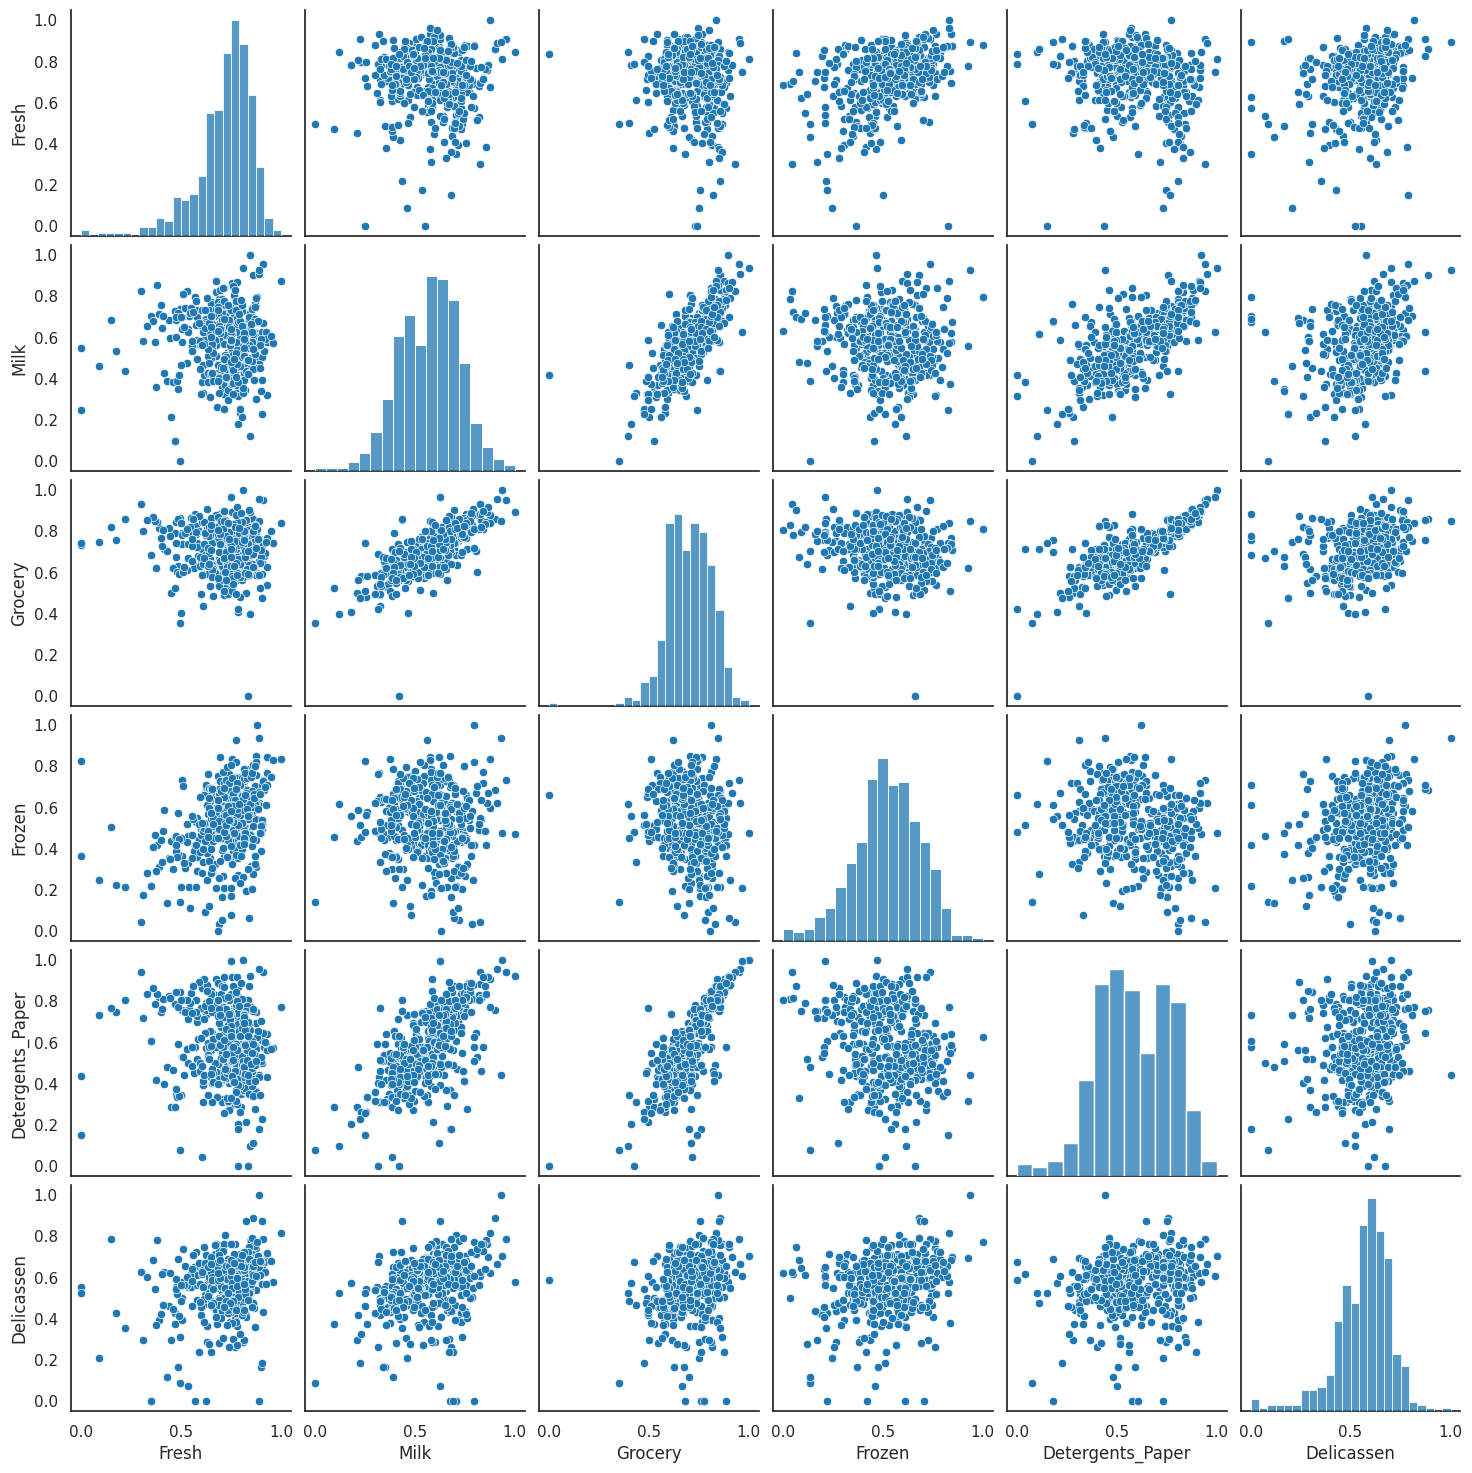

In [13]:
sns.set_context('notebook')
sns.set_style('white')
sns.pairplot(data);

Part 3
In this section, we will:

Using Scikit-learn's pipeline function, recreate the data pre-processing scheme above (transformation and scaling) using a pipeline. If you used a non-Scikit learn function to transform the data (e.g. NumPy's log function), checkout the custom transformer class called FunctionTransformer.
Use the pipeline to transform the original data that was stored at the end of question 1.
Compare the results to the original data to verify that everything worked.
Note: Scikit-learn has a more flexible Pipeline function and a shortcut version called make_pipeline. Either can be used. Also, if different transformations need to be performed on the data, a FeatureUnion can be used.

In [15]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# The custom NumPy log transformer
log_transformer = FunctionTransformer(np.log1p)

# The pipeline
estimators = [('log1p', log_transformer), ('minmaxscale', MinMaxScaler())]
pipeline = Pipeline(estimators)

# Convert the original data
data_pipe = pipeline.fit_transform(data_orig)

The results are identical. Note that machine learning models and grid searches can also be added to the pipeline (and in fact, usually are.)

In [16]:
np.allclose(data_pipe, data)

True

Part 4
In this section, we will:

Perform PCA with n_components ranging from 1 to 5.
Store the amount of explained variance for each number of dimensions.
Also store the feature importance for each number of dimensions. Hint: PCA doesn't explicitly provide this after a model is fit, but the components_ properties can be used to determine something that approximates importance. How you decided to do so is entirely up to you.
Plot the explained variance and feature importances.

In [17]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):

    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)

    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))

    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n,
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')

Create a table of feature importances for each data column.

In [18]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features  Delicassen  Detergents_Paper     Fresh    Frozen   Grocery      Milk
n                                                                             
1           0.071668          0.335487  0.060620  0.095979  0.190236  0.246010
2           0.151237          0.177519  0.158168  0.222172  0.112032  0.178872
3           0.165518          0.145815  0.211434  0.268363  0.084903  0.123967
4           0.224259          0.149981  0.239527  0.214275  0.070971  0.100987
5           0.211840          0.182447  0.196382  0.178104  0.067338  0.163888

Create a plot of explained variances.

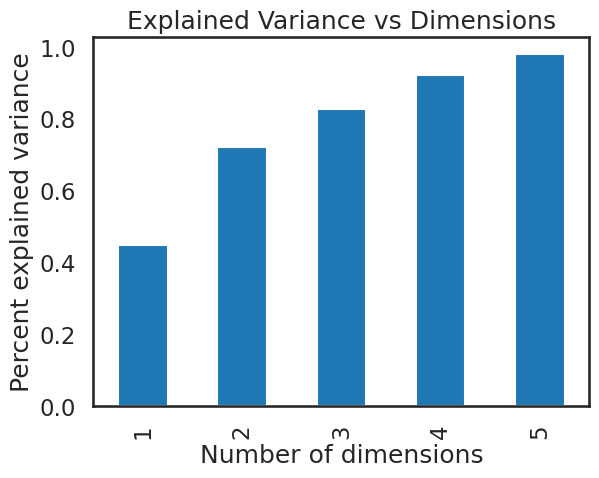

In [19]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

And here's a plot of feature importances.

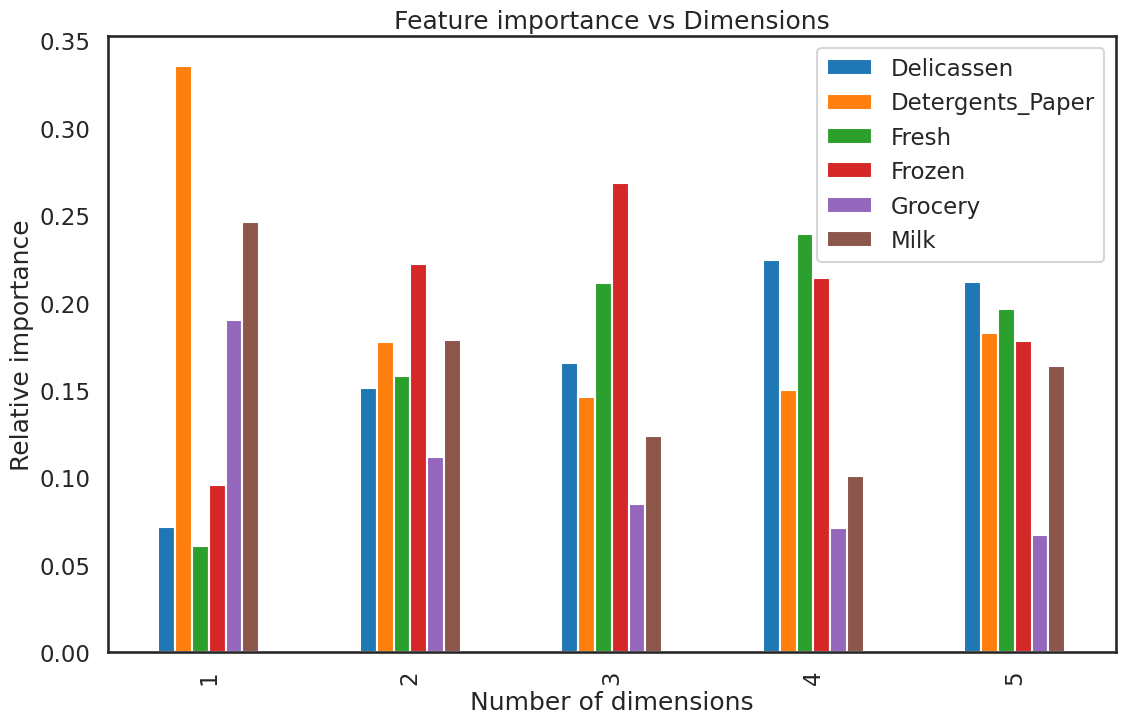

In [20]:
ax = features_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

This concludes "Demo lab: Dimensionality Reduction (Part 1)". We will be going over the remaining parts in the next module.

TASK 2
Task 2 covers part 5 and 6. It includes KernelPCA and Model accuracy.

Note: Task 1 is a pre-requisite for this task. Please make sure you complete Task 1 before proceeding to Task 2.


Part 5
In this section, we will:

Fit a KernelPCA model with kernel='rbf'. You can choose how many components and what values to use for the other parameters (rbf refers to a Radial Basis Function kernel, and the gamma parameter governs scaling of this kernel and typically ranges between 0 and 1). Several other kernels can be tried, and even passed ss cross validation parameters (see this example).
If you want to tinker some more, use GridSearchCV to tune the parameters of the KernelPCA model.
The second step is tricky since grid searches are generally used for supervised machine learning methods and rely on scoring metrics, such as accuracy, to determine the best model. However, a custom scoring function can be written for GridSearchCV, where larger is better for the outcome of the scoring function.

What would such a metric involve for PCA? What about percent of explained variance? Or perhaps the negative mean squared error on the data once it has been transformed and then inversely transformed?

In [21]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Custom scorer--use negative rmse of inverse transform
def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X

    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)

    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())

    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

# The grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}

# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(data)

kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=1.0, kernel='rbf', n_components=4)

Part 6
Let's explore how our model accuracy may change if we include a PCA in our model building pipeline. Let's plan to use sklearn's Pipeline class and create a pipeline that has the following steps:

A scaler
`PCA(n_components=n)`
`LogisticRegression`
Load the Human Activity data from the datasets.
Write a function that takes in a value of n and makes the above pipeline, then predicts the "Activity" column over a 5-fold StratifiedShuffleSplit, and returns the average test accuracy
For various values of n, call the above function and store the average accuracies.
Plot the average accuracy by number of dimensions.

In [22]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')

In [23]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = data.drop('Activity', axis=1)
y = data.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(solver='liblinear'))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

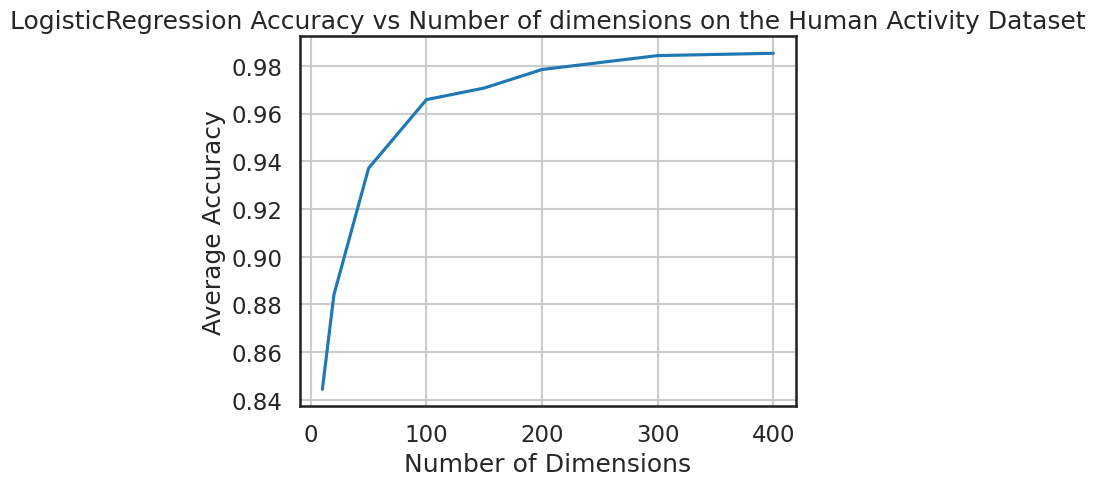

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt # Import the matplotlib library

sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)

lab 2

Kernel Principal Component Analysis
Estimated time needed: 45 minutes

Rumor has it that the ultra-wealthy community consists of either investment bankers or entrepreneurs in the tech industry that dropped out of college. Is that stereotype really true? Ever wonder if the top billionaires in the world share anything in common? Although, we can't say with certainty what it takes to be one, we do have a way to determine if any patterns exist among the richest people in the world.

In this notebook, you will explore Kernel Principal Component Analysis (Kernel PCA) - an extension of principal component analysis (PCA) - to extract key feature patterns in the dataset, which is usually of higher dimension. In addition to analyzing billionaires around the globe, we will also use this unsupervised learning technique to denoise images.



Table of Contents
Objectives
Datasets
Setup
Installing Required Libraries
Importing Required Libraries
Defining Helper Functions
Background
What does PCA do?
Visual Example - Transform a Dataset Before Applying PCA
Apply PCA
Transform a Dataset to a Higher Dimension and Then Apply PCA
Kernel PCA
What's a Kernel?
Applying Kernel PCA
Using Kernel PCA to Predict if You're the Richest Person in the World
Data Analysis
Applying Kernel PCA
Using Kernel PCA to Improve Visualization
Using Kernel PCA to Improve Prediction
Exercises

Exercise 1 - Fitting PCA and Kernel PCA Objects
Exercise 2 - Reconstruct the Digits
Exercise 3 - Visualize Denoised Digit Images
Objectives
After completing this lab, you will be able to:

Understand why we transform a dataset to a higher dimension and apply PCA.
Understand what is Kernel PCA.
Apply Kernel PCA effectively to real world datasets for purposes ranging from prediction to visualization.
Datasets
Datasets for this lab are gathered from the kaggle under the Public Domain License.

Setup
For this lab, we will be using the following libraries:

pandas for managing the data.
numpy for mathematical operations.
sklearn for machine learning and machine-learning-pipeline related functions.
seaborn for visualizing the data.
matplotlib for additional plotting tools.

Installing Required Libraries
The following required modules are pre-installed in the Skills Network Labs environment. However if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Anaconda) you will need to install these libraries by removing the # sign before !mamba in the following code cell.

In [28]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba   install pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==1.0.2
# Note: If your environment doesn't support "!mamba install", use "!pip install pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==1.0.2"

In [29]:
!pip install --upgrade scikit-learn

Importing Required Libraries

In [30]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

Defining Helper Functions






This function will plot projections onto a vector.

In [31]:
def plot_proj(A,v,y,name=None):

    plt.scatter(A[:,0],A[:,1],label='data',c=y,cmap='viridis')

    #plt.plot(np.linspace(A[:,0].min(),A[:,0].max()),np.linspace(A[:,1].min(),A[:,1].max())*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)
    plt.plot(np.linspace(-1,1),np.linspace(-1,1)*(v[1]/v[0]),color='black',linestyle='--',linewidth=1.5,label=name)
    # Run through all the data

    for i in range(len(A[:,0])-1):
        #data point
        w=A[i,:]

        # projection
        cv = (np.dot( A[i,:],v))/np.dot(v,np.transpose(v))*v

        # line between data point and projection
        plt.plot([A[i,0],cv[0]],[A[i,1],cv[1]],'r--',linewidth=1.5)
    plt.plot([A[-1,0],cv[0]],[A[-1,1],cv[1]],'r--',linewidth=1.5,label='projections' )
    plt.legend()
    plt.show()

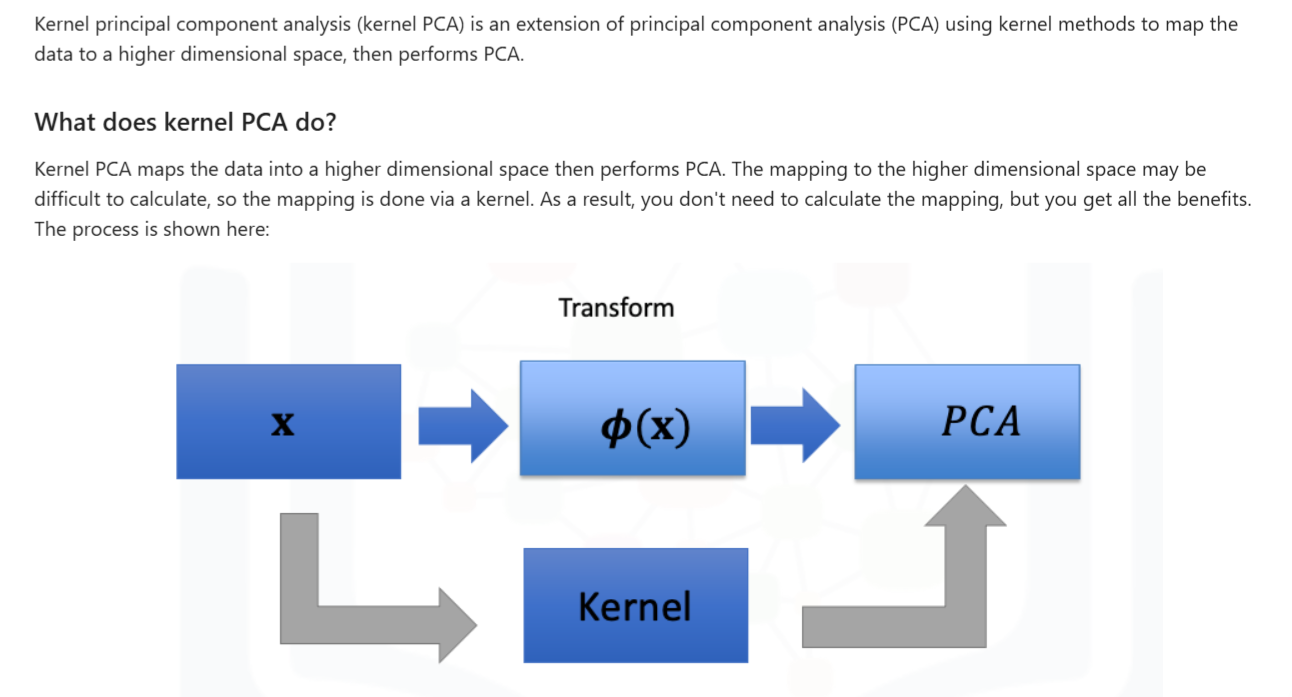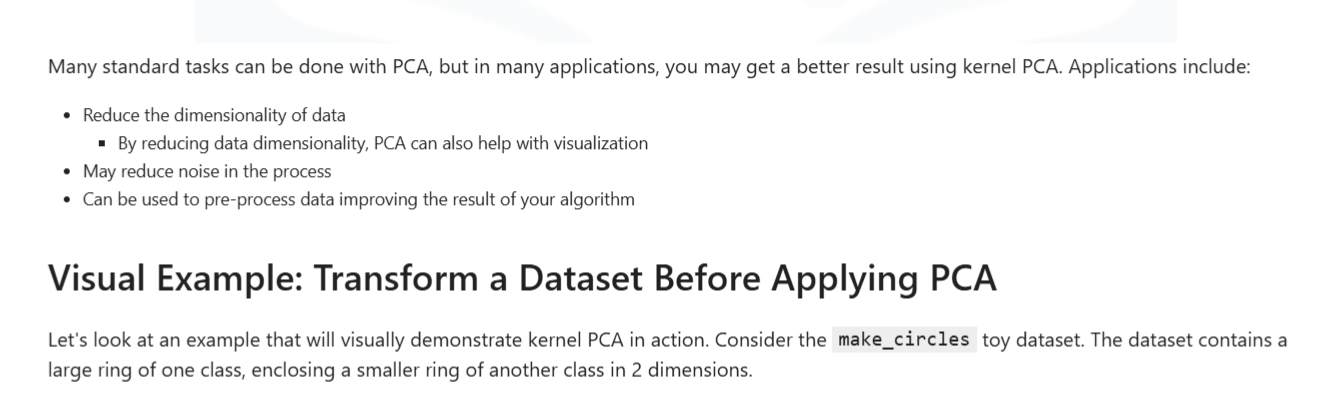

In [32]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create the toy dataset
X, y = make_circles(n_samples=1000, factor=0.01, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

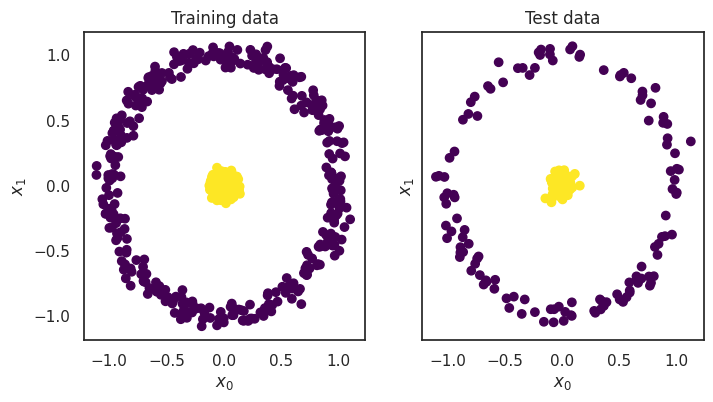

In [33]:
# Visualize the data
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='viridis')
train_ax.set_xlabel("$x_{0}$")
train_ax.set_ylabel("$x_{1}$")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,cmap='viridis')
test_ax.set_xlabel("$x_{0}$")
test_ax.set_ylabel("$x_{1}$")
test_ax.set_title("Test data")
plt.show()

Apply PCA
There are several issues with the dataset above, the first being samples from each class cannot be linearly separated: no plane can split the samples of the inner ring from the outer ring. Let's see what happens when we perform PCA and evaluate the projection or score.

In [34]:
from sklearn.decomposition import PCA

# Fit on a PCA object
pca = PCA(n_components=2)

score_pca = pca.fit(X_train).transform(X_test)
pca

PCA(n_components=2)

We can plot the 2 principal components:

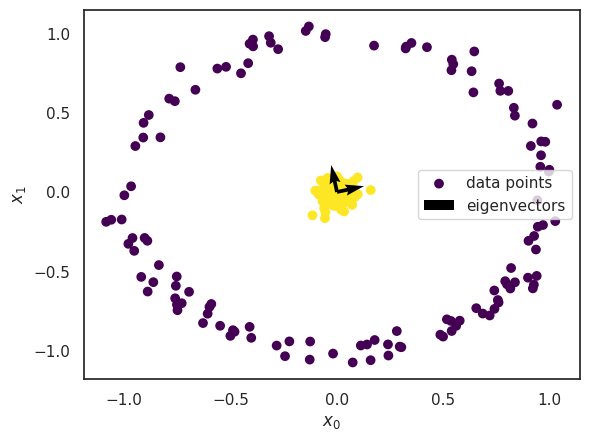

In [35]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,label="data points", cmap='viridis')
plt.quiver([0,0],[0,0], pca.components_[0,:], pca.components_[1,:], label="eigenvectors")
plt.xlabel("$x_{0}$")
plt.ylabel("$x_{1}$")
plt.legend(loc='center right')
plt.show()

The following red lines show the direction of projection onto the first principal component (the black dotted line) for each data point.

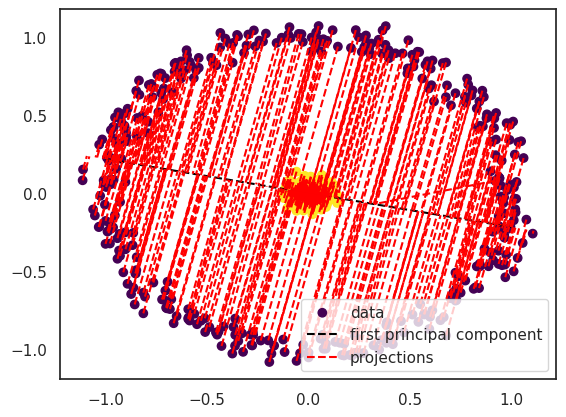

In [36]:
plot_proj(X_train,pca.components_[0,:],y_train,"first principal component")

We can also plot out the actual points of projection onto the first principal component, which are also known as their scores for the PC. We see that the dataset is not linearly separable, as data points from different classes cannot be separated with a plane:

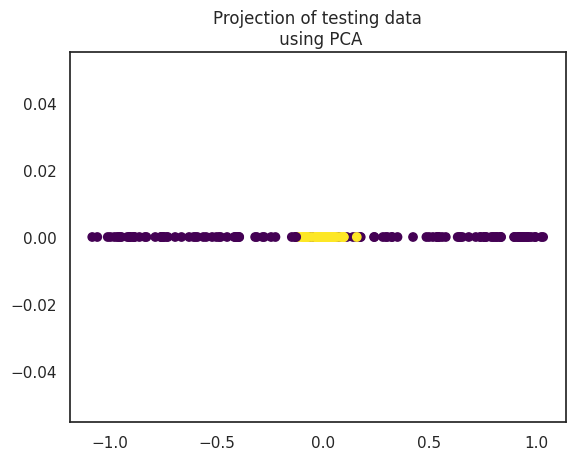

In [37]:
plt.scatter(score_pca [:,0],np.zeros(score_pca[:,0].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

If we plot the projection onto both principal components, we see the data looks the same, or isotropic, meaning that it has the same value when measured in a different coordinate system. This is because the data is symmetric and the variance is equal on each side. As a result, PCA will not help us classify the data.

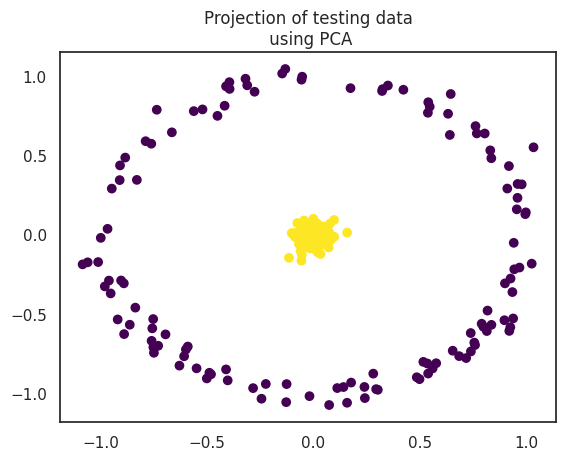

In [38]:
plt.scatter(score_pca[:, 0], score_pca[:, 1], c=y_test,cmap='viridis')
plt.title("Projection of testing data\n using PCA")
plt.show()

Building a Logistic Regression model on the training set, we can see that the accuracy score is around 50%, suggesting that the model is arbitrarily worse. Hence, we can see that it'd be unsuitable to project the data onto a low-dimensional linear subspace.

In [39]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression().fit(X_train, y_train)
print(str.format("Test set  mean accuracy score for for PCA: {}", lr.score(X_test, y_test)))

Test set  mean accuracy score for for PCA: 0.496


Transform a Dataset to a Higher Dimension and then Apply PCA¶
Instead, let's first apply the following polynomial transformation to the data:







𝜙(𝐱)=\[𝑥_1,𝑥_2,𝑥_12+𝑥_22]
𝜙
(
𝑥
)
=
\[
𝑥
_
1
,
𝑥
_
2
,
𝑥
_
1
2
+
𝑥
_
2
2
]
  where  𝐱=\[𝑥_1,𝑥_2]

In [40]:
PHI_train=np.concatenate((X_train, (X_train**2).sum(axis=1).reshape(-1,1)),axis=1)
PHI_test=np.concatenate((X_test, (X_test**2).sum(axis=1).reshape(-1,1)),axis=1)

We can plot the result where on the horizontal axis we have  𝑥_1
𝑥
_
1
  and  𝑥_2
𝑥
_
2
 , and on the vertical axis we have  𝑥_12+𝑥_22
𝑥
_
1
2
+
𝑥
_
2
2
 . We see that the larger ring has been mapped upwards in the vertical direction as the sum of its squared components is larger.

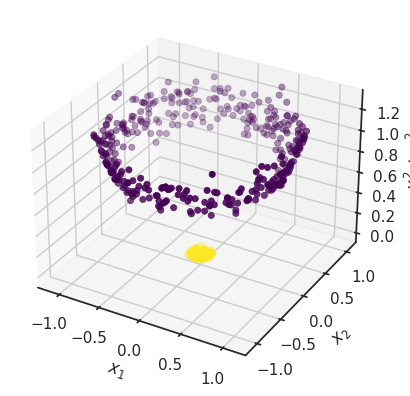

In [41]:
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PHI_train[:,0], PHI_train[:,1],  PHI_train[:,2], c=y_train, cmap='viridis', linewidth=0.5);
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.set_zlabel('$x_{1}^2+x_{2}^2$')
plt.show()

We then perform PCA on this transformed data, specifying we want to keep the top three principal components.

In [42]:
pca = PCA(n_components=3)
score_polly = pca.fit(PHI_train).transform(PHI_test)

pca = PCA(n_components=3)
score_polly = pca.fit(PHI_train).transform(PHI_test)
Again, like we have previously done, we can plot out the data points' projection onto the first PC/scores. Below, we see that the dataset is almost linearly separable.

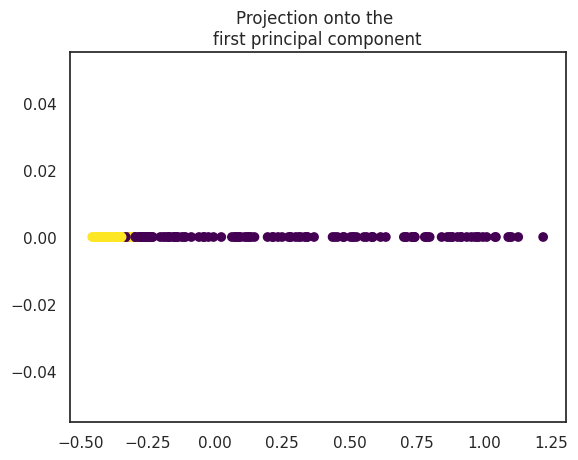

In [43]:
plt.scatter(score_polly[:,0],np.zeros(score_polly[:,1].shape[0]),c=y_test,cmap='viridis')
plt.title("Projection onto the \nfirst principal component")
plt.show()

Projecting onto a plane formed by the top two principal components (the ones with the largest absolute eigenvalues), we see the dataset is linearly separable with the exception of a couple of points.

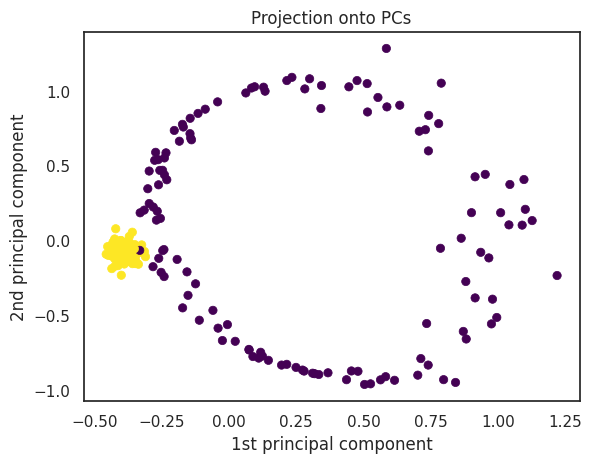

In [44]:
plt.scatter(score_polly[:,0], score_polly[:,1],c=y_test, cmap='viridis', linewidth=0.5);
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection onto PCs")
plt.show()


By building a Logistic Regression model on the training set, we see the accuracy is much better

In [45]:
lr= LogisticRegression().fit(PHI_train, y_train)
print(str.format("Test set  mean accuracy score for for Kernal PCA: {}", lr.score(PHI_test, y_test)))

Test set  mean accuracy score for for Kernal PCA: 1.0


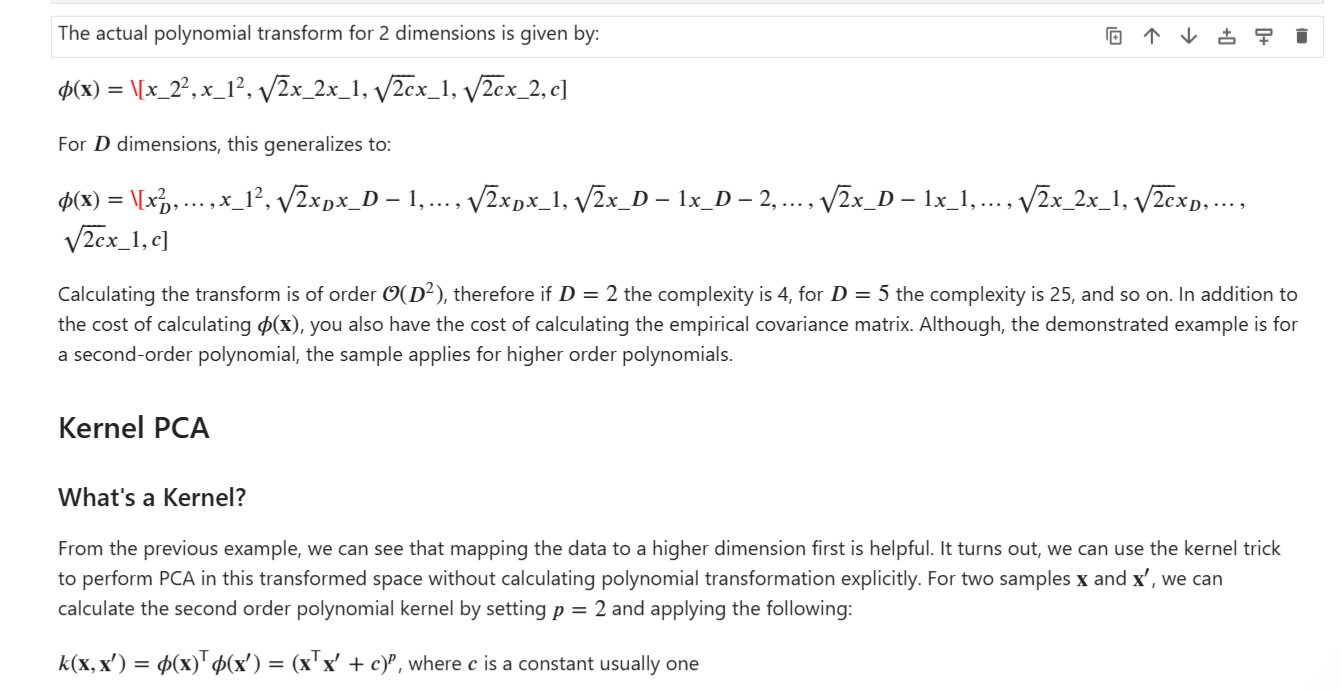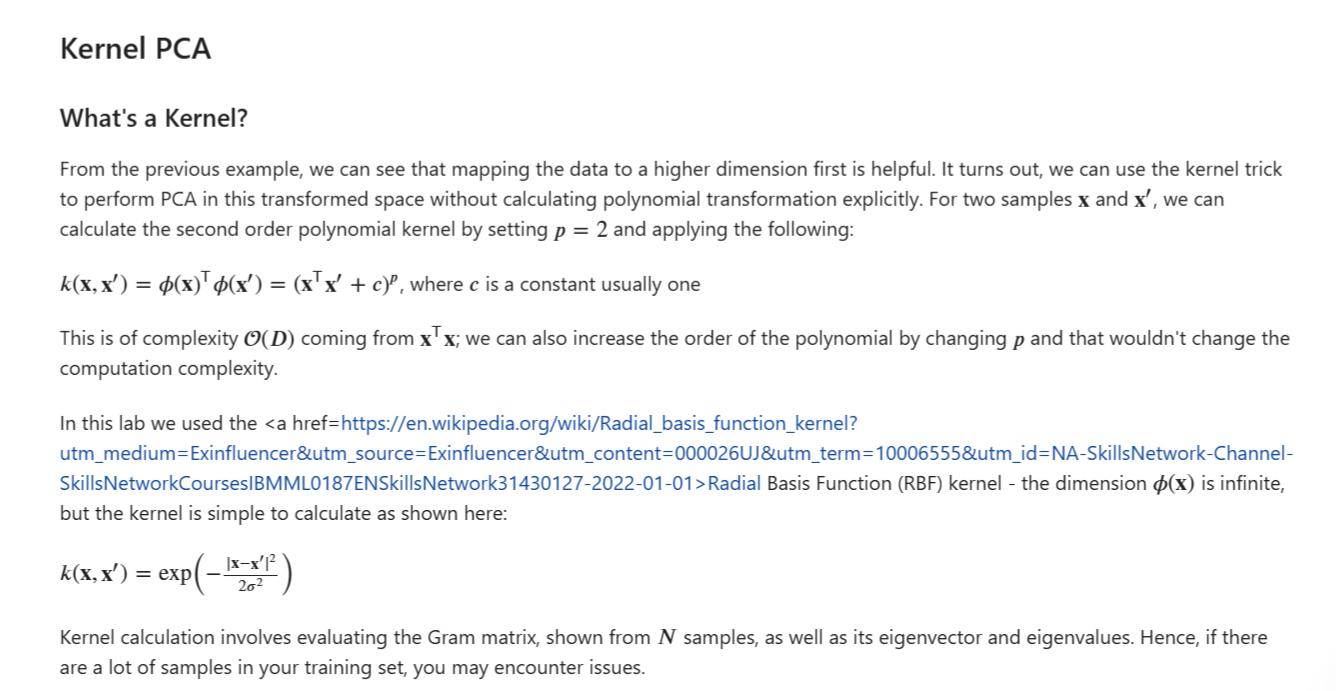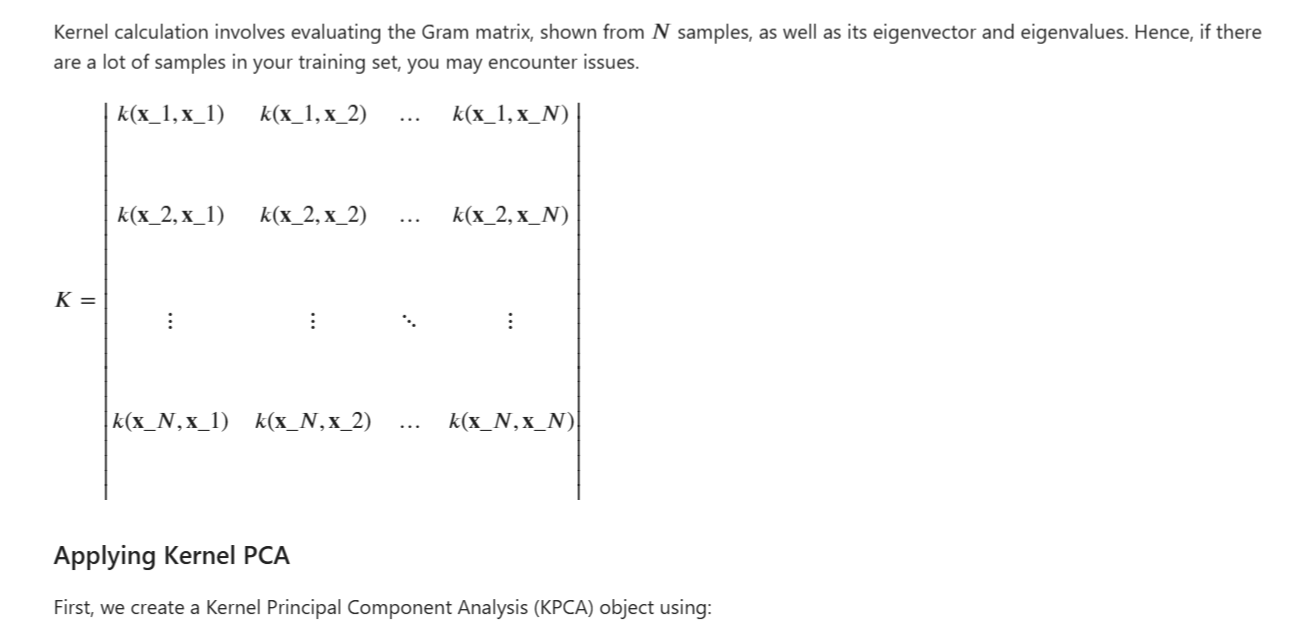

In [46]:
kernel_pca = KernelPCA( kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)

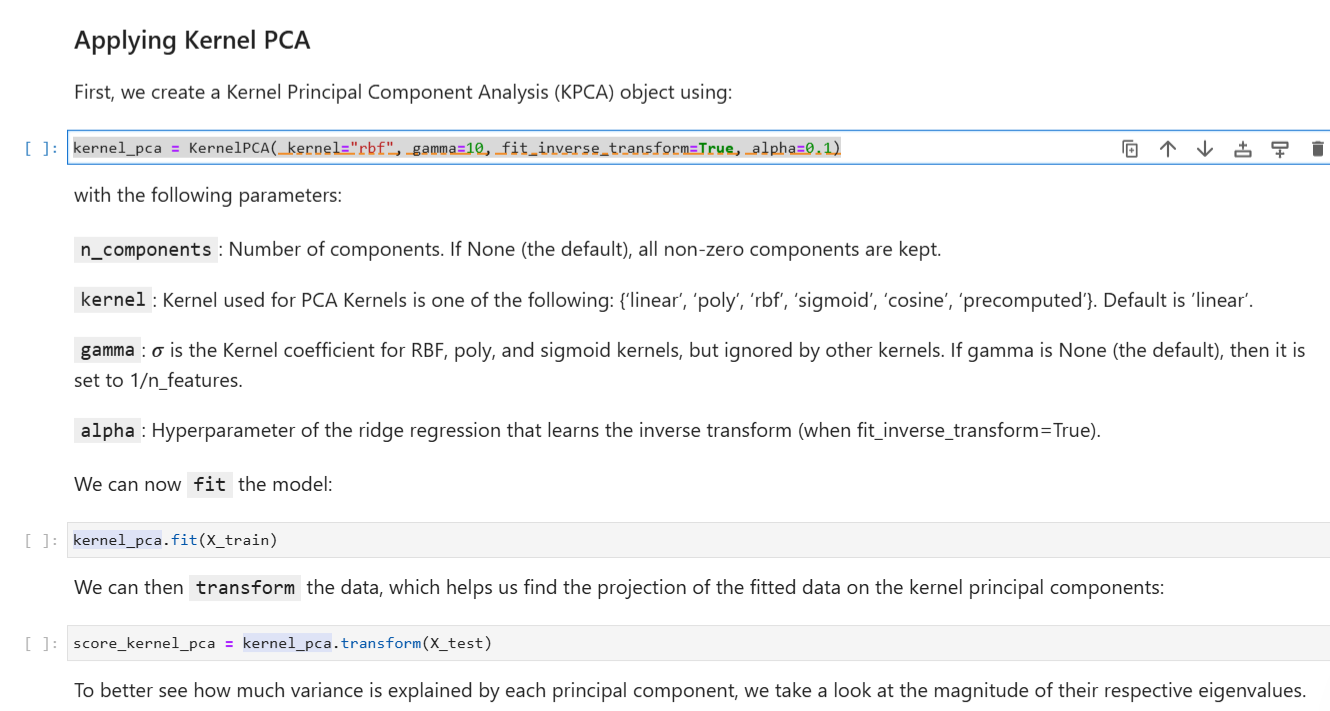

In [47]:
kernel_pca.fit(X_train)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=10, kernel='rbf')

In [48]:
score_kernel_pca = kernel_pca.transform(X_test)

To better see how much variance is explained by each principal component, we take a look at the magnitude of their respective eigenvalues. Below, you can see that the first few principal components have the largest absolute eigenvalue, and the values continues to decrease after that.

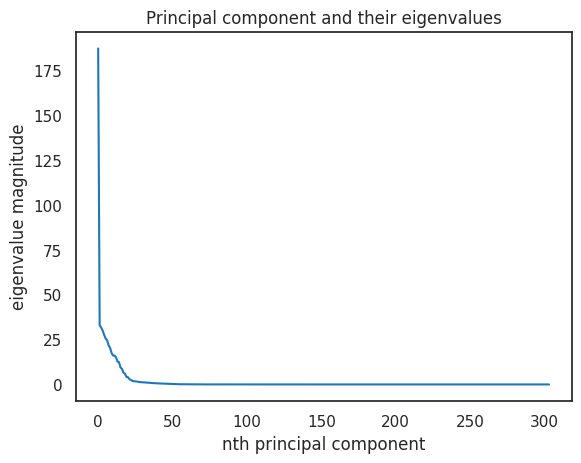

In [49]:
plt.plot(kernel_pca.eigenvalues_)

plt.title("Principal component and their eigenvalues")
plt.xlabel("nth principal component")
plt.ylabel("eigenvalue magnitude")
plt.show()

Again, by plotting the data points' projection onto the first two principal components, we can see that the data is linearly separable, demonstrating that kernel PCA performs better than our polynomial approximation:

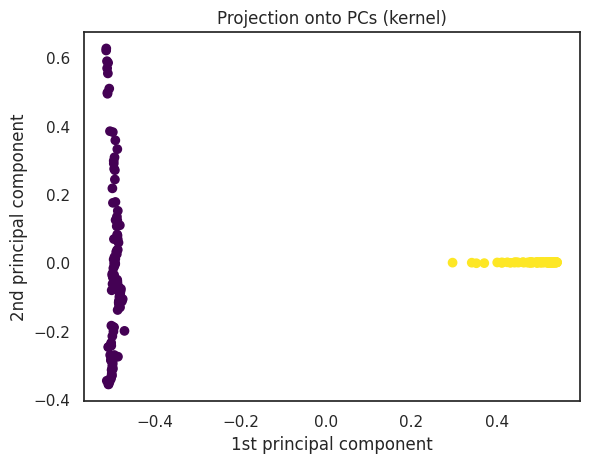

In [50]:
plt.scatter(score_kernel_pca[:,0],score_kernel_pca[:,1] ,c=y_test,cmap='viridis')
plt.title("Projection onto PCs (kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

In PCA, the reconstruction was exactly the same as the original component, if n_components is equal to the dimension of the original features. On the other hand, Kernel PCA does not actually span  𝜙(𝐱)
𝜙
(
𝑥
)
  but instead spans a subspace. Therefore, the inverse transformation will not always reconstruct the data, like in PCA. We can verify this by comparing the inverse transformation of Kernel PCA and PCA.

In [51]:
X_hat_kpca = kernel_pca.inverse_transform(kernel_pca.transform(X_test))

pca = PCA(n_components=2)
pca.fit(X_train)
X_hat_pca = pca.inverse_transform(pca.transform(X_test))

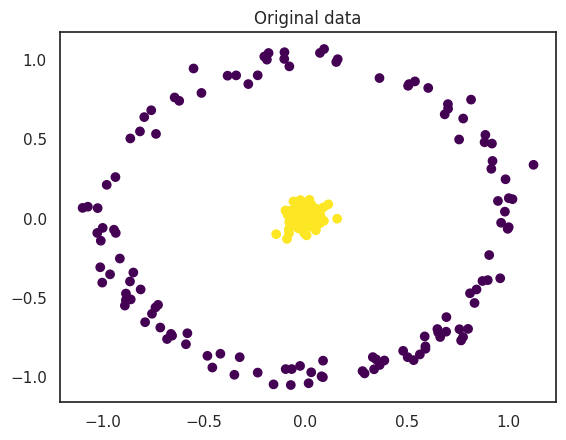

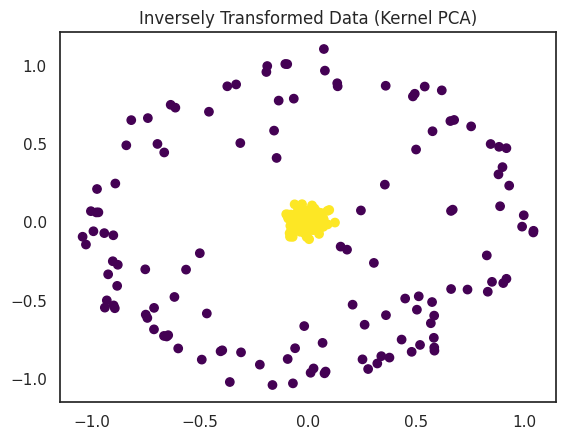

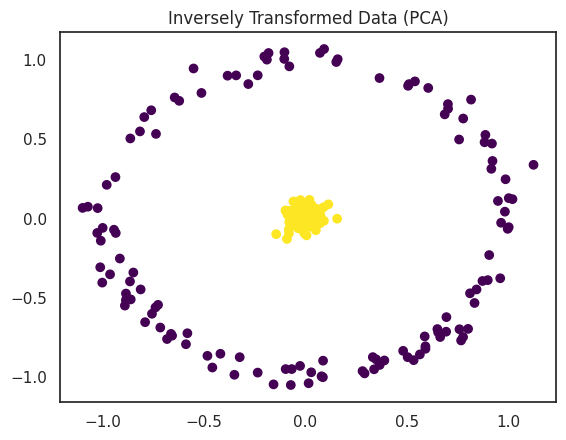

In [52]:
plt.scatter(X_test[:,0],X_test[:,1] ,c=y_test,cmap='viridis')
plt.title("Original data")
plt.show()

plt.scatter(X_hat_kpca[:,0],X_hat_kpca[:,1] ,c=y_test,cmap='viridis')
plt.title("Inversely Transformed Data (Kernel PCA)")
plt.show()

plt.scatter(X_hat_pca[:,0],X_hat_pca[:,1] ,c=y_test,cmap='viridis')
plt.title("Inversely Transformed Data (PCA)")
plt.show()

We can also calculate the error in the mean squared error for the inverse transformation, which is larger for Kernel PCA than for PCA, whose MSE is approximately 0, since the transformed data for it is identical to the original.

In [53]:
print ("Mean squared error for Kernel PCA is:",((X_test-X_hat_kpca)**2).mean())

Mean squared error for Kernel PCA is: 0.011275231727641381


In [54]:
print("Mean squared error PCA is:" ,((X_test-X_hat_pca)**2).mean())

Mean squared error PCA is: 5.8139812353534686e-33


Using Kernel PCA to Predict if You're the Richest Person in the World
Returning back to the question posed at the beginning of this lab, let's see if we can use Kernel PCA to help us better visualize if any trends exist among the richest people in the world. "The World's Billionaires" is an annual ranking documenting the net worth of the wealthiest billionaires in the world, compiled and published in March, annually, by the American business magazine - Forbes. For this lab, we obtained the dataset from here.

The features available from the dataset are:

Rank
Name
Net Worth - their net worth in billions USD
Age
Country
Source - their source of income
Industry - sector/industry/market segment in which each billionaire has made their fortune
Data Analysis






We load the dataset and take a look to see if it loaded properly.

In [55]:
# Download the dataset and read it into a Pandas dataframe
df=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/billionaires.csv',index_col="Unnamed: 0")
df.head()

rank                       name networth  age        country  \
0     1                 Elon Musk    $219 B   50  United States   
1     2                Jeff Bezos    $171 B   58  United States   
2     3  Bernard Arnault & family    $158 B   73         France   
3     4                Bill Gates    $129 B   66  United States   
4     5            Warren Buffett    $118 B   91  United States   

               source                industry  
0       Tesla, SpaceX             Automotive   
1              Amazon             Technology   
2                LVMH       Fashion & Retail   
3           Microsoft             Technology   
4  Berkshire Hathaway  Finance & Investments

In [56]:
df.shape

(2600, 7)

For each column, we can take a look at its unique values.

In [57]:
for col in df:
    print(str.format("{} has {} unique values.", col, len(df[col].unique())))

rank has 228 unique values.
name has 2598 unique values.
networth has 228 unique values.
age has 76 unique values.
country has 75 unique values.
source has 895 unique values.
industry has 18 unique values.


Notably, there are only 228 unique rank values, which is due to many ties in the rankings.

In [58]:
df[-100:-1]

rank                     name networth  age        country  \
2500  2448             Koo Bon-sik    $1.1 B   63    South Korea   
2501  2448          Suresh Krishna    $1.1 B   85          India   
2502  2448            Nancy Lerner    $1.1 B   61  United States   
2503  2448            Norma Lerner    $1.1 B   86  United States   
2504  2448         Randolph Lerner    $1.1 B   60  United States   
...    ...                      ...      ...  ...            ...   
2594  2578                 Fu Gang      $1 B   51          China   
2595  2578  Jorge Gallardo Ballart      $1 B   80          Spain   
2596  2578            Nari Genomal      $1 B   82    Philippines   
2597  2578          Ramesh Genomal      $1 B   71    Philippines   
2598  2578          Sunder Genomal      $1 B   68    Philippines   

                     source                industry  
2500                     LG             Technology   
2501             auto parts             Automotive   
2502  banking, credit cards  Finance & Investments   
2503                banking  Finance & Investments   
2504  banking, credit cards  Finance & Investments   
...                     ...                     ...  
2594       pharma retailing             Healthcare   
2595        pharmaceuticals             Healthcare   
2596                apparel       Fashion & Retail   
2597                apparel       Fashion & Retail   
2598               garments       Fashion & Retail   

[99 rows x 7 columns]

lso, we note that there are a lot of unique values for source and names, suggesting that they possibly won't help with rank prediction and can be excluded in our task. To examine the categorical variables country andindustry, we plot their respective histograms:

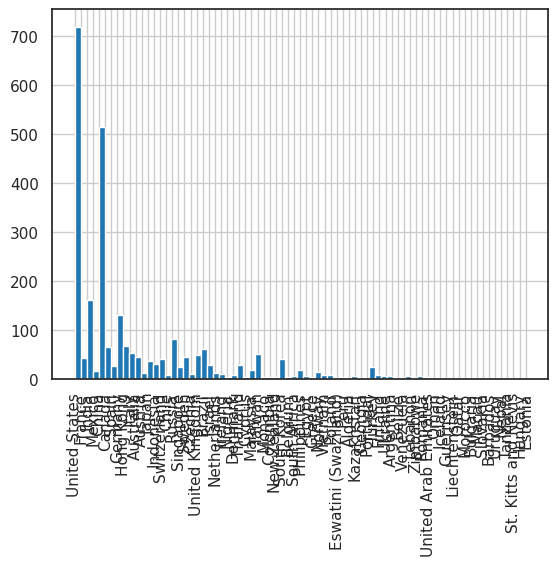

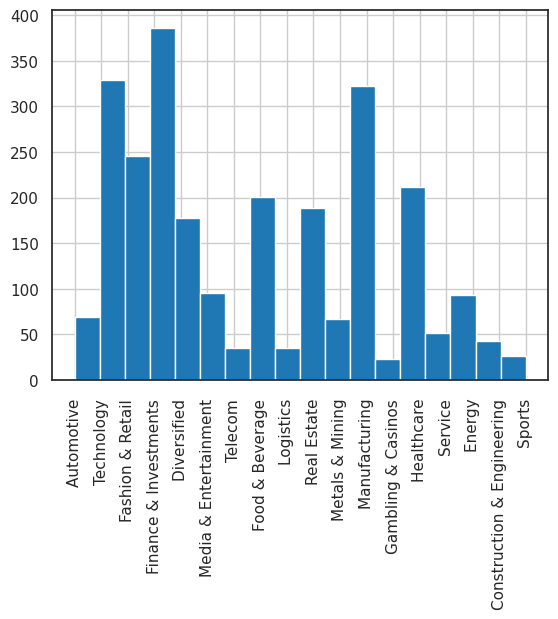

In [59]:
for column in ['country','industry']:

    df[column].hist(bins=len(df[column].unique()))
    plt.xticks(rotation='vertical')
    plt.show()

We can see that in this dataset, certain countries and industries contain more billionaires than others. We also examine the pairwise plot and correlation coefficient between age and rank, which tells us that the two features are negatively correlated.

age      rank
age   1.000000 -0.124947
rank -0.124947  1.000000

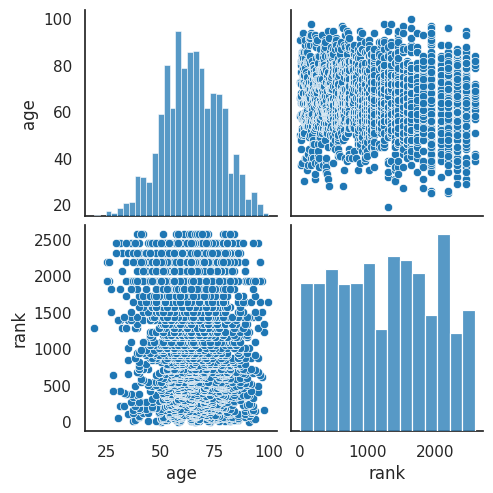

In [60]:
sns.pairplot(df[['age','rank']])
df[['age','rank']].corr()

or the variables that we don't use in prediction, we can save them separately:

In [61]:
B_names,networths,sources,industrys=df['name'],df['networth'],df['source'],df['industry']
B_names,networths,sources,industrys

(0                      Elon Musk 
 1                     Jeff Bezos 
 2       Bernard Arnault & family 
 3                     Bill Gates 
 4                 Warren Buffett 
                   ...            
 2595      Jorge Gallardo Ballart 
 2596                Nari Genomal 
 2597              Ramesh Genomal 
 2598              Sunder Genomal 
 2599       Horst-Otto Gerberding 
 Name: name, Length: 2600, dtype: object,
 0       $219 B
 1       $171 B
 2       $158 B
 3       $129 B
 4       $118 B
          ...  
 2595      $1 B
 2596      $1 B
 2597      $1 B
 2598      $1 B
 2599      $1 B
 Name: networth, Length: 2600, dtype: object,
 0                Tesla, SpaceX
 1                       Amazon
 2                         LVMH
 3                    Microsoft
 4           Berkshire Hathaway
                  ...          
 2595           pharmaceuticals
 2596                   apparel
 2597                   apparel
 2598                  garments
 2599    flavors and fragrances

In [62]:
y=df['rank']
y.head()

0    1
1    2
2    3
3    4
4    5
Name: rank, dtype: int64

In [63]:
df.drop(columns=['name','networth','source'],inplace=True)
df.head()

rank  age        country                industry
0     1   50  United States             Automotive 
1     2   58  United States             Technology 
2     3   73         France       Fashion & Retail 
3     4   66  United States             Technology 
4     5   91  United States  Finance & Investments

Since our categorical variables country and industry are not ordinal, meaning that the categories don't have a specific order, we utilize one-hot encoding to convert their levels into dummy variables. Other remaining variables in the dataset don't require this, so we specify remainder="passthrough" to exclude them from the encoding. The features will then be assigned to the variable data.

In [64]:
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), ['country','industry']) ],remainder="passthrough")
data=one_hot.fit_transform(df)

As of now, the output is a NumPy array, so let's get the feature names from the one_hot object using the method get_feature_names_out(), which will give us the feature name with the name of the transformer as a prefix. For one-hot encoding, the prefix will also include the name of the column that generated the feature. Hence, we can strip out the prefix of the string for column names and save the labelled array as a dataframe:

In [65]:
names=one_hot.get_feature_names_out()
column_names=[name[name.find("_")+1:] for name in  [name[name.find("__")+2:] for name in names]]
new_data=pd.DataFrame(data.toarray(),columns=column_names)
new_data.head()

Algeria  Argentina  Australia  Austria  Barbados  Belgium  Belize  Brazil  \
0      0.0        0.0        0.0      0.0       0.0      0.0     0.0     0.0   
1      0.0        0.0        0.0      0.0       0.0      0.0     0.0     0.0   
2      0.0        0.0        0.0      0.0       0.0      0.0     0.0     0.0   
3      0.0        0.0        0.0      0.0       0.0      0.0     0.0     0.0   
4      0.0        0.0        0.0      0.0       0.0      0.0     0.0     0.0   

   Bulgaria  Canada  ...  Manufacturing   Media & Entertainment   \
0       0.0     0.0  ...             0.0                     0.0   
1       0.0     0.0  ...             0.0                     0.0   
2       0.0     0.0  ...             0.0                     0.0   
3       0.0     0.0  ...             0.0                     0.0   
4       0.0     0.0  ...             0.0                     0.0   

   Metals & Mining   Real Estate   Service   Sports   Technology   Telecom   \
0               0.0           0.0       0.0      0.0          0.0       0.0   
1               0.0           0.0       0.0      0.0          1.0       0.0   
2               0.0           0.0       0.0      0.0          0.0       0.0   
3               0.0           0.0       0.0      0.0          1.0       0.0   
4               0.0           0.0       0.0      0.0          0.0       0.0   

   rank   age  
0   1.0  50.0  
1   2.0  58.0  
2   3.0  73.0  
3   4.0  66.0  
4   5.0  91.0  

[5 rows x 95 columns]

Applying Kernel PCA¶






Let's define a Kernel PCA object and fit it on this new data:

In [66]:
kernel_pca = KernelPCA(kernel="rbf" ,fit_inverse_transform=True, alpha=0.1)
kernel_score=kernel_pca.fit_transform(new_data)

Using Kernel PCA to Improve Visualization¶
By plotting out the projection on the first two principal components and overlaying the plot with rank as the color, we are able to see a two dimensional visualization of the dataset, which can help distinguish any clusters that may be present in rankings. Here, the variable ranking was also defined, which will label the plot with the industry of the individual with that ranking value.

In [67]:
ranking=13

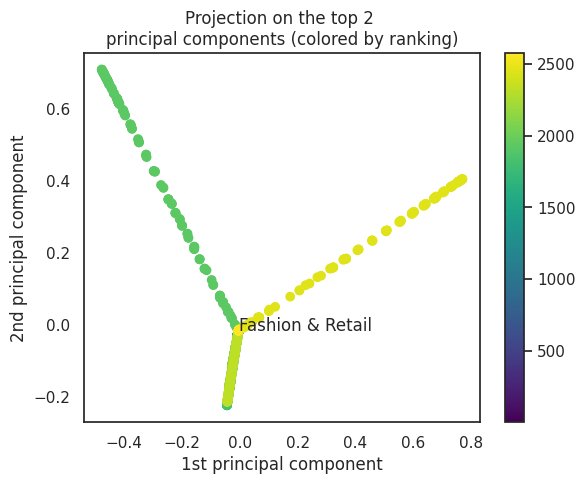

In [68]:
fig, ax = plt.subplots()

sc=ax.scatter(kernel_score[:,0],kernel_score[:,1] ,c=y,cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.annotate(industrys[ranking], (kernel_score[ranking,0],kernel_score[ranking,1]))
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.title("Projection on the top 2 \nprincipal components (colored by ranking)")
plt.show()

We see a Bifurcation of the data dependent on the rank. The diverging branches suggest that difference in ranking can be associated with certain patterns in the data. This becomes more apparent in the 3-dimensional projection space:

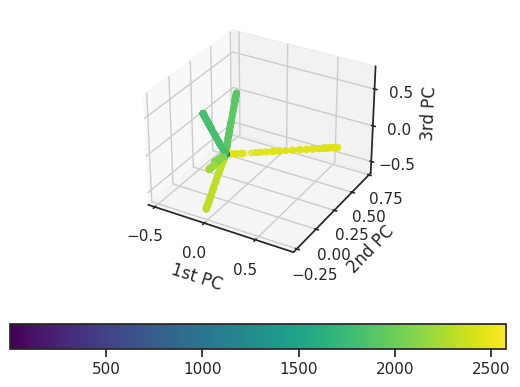

In [69]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(kernel_score[:,0], kernel_score[:,1],  kernel_score[:,2], c=y, cmap='viridis', linewidth=0.5);
fig.colorbar(sc, orientation='horizontal')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

Each line corresponds to a different range of ranking (represented by the varying colors), so let's see what happens when we apply PCA and plot the projection space in 1, 2, and 3 dimensions respectively.

In [70]:
pca = PCA()
score_pca = pca.fit_transform(new_data)

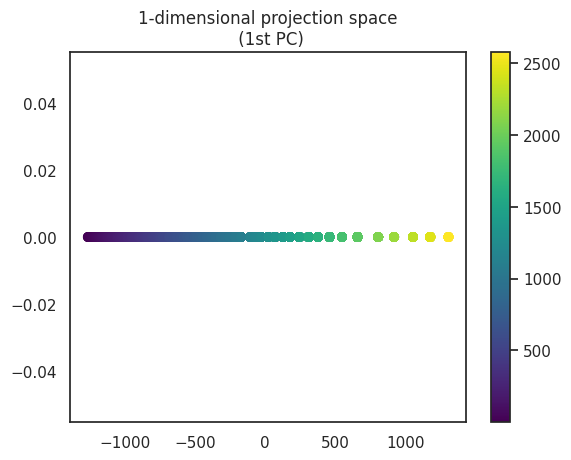

In [71]:
fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],np.zeros(score_pca[:,1].shape ),c=y,cmap='viridis')
ax.set_title('1-dimensional projection space\n (1st PC)')
fig.colorbar(sc, orientation='vertical')
plt.show()

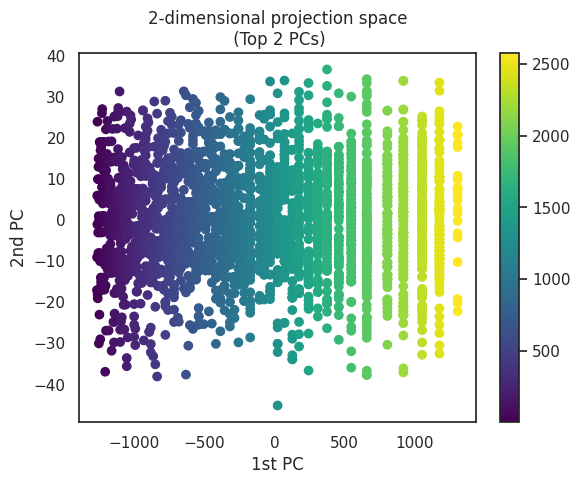

In [72]:
fig, ax = plt.subplots()
sc=ax.scatter(score_pca[:,0],score_pca[:,1] ,c=y,cmap='viridis')
fig.colorbar(sc, orientation='vertical')
ax.set_title('2-dimensional projection space\n (Top 2 PCs)')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()

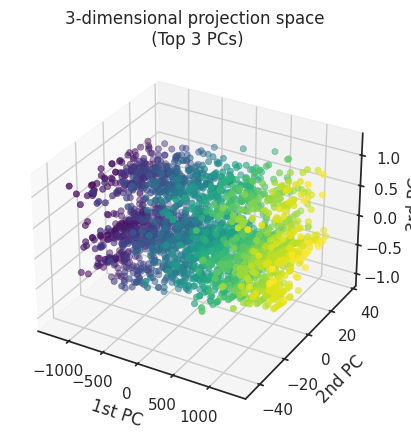

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc=ax.scatter(score_pca[:,0], score_pca[:,1],  score_pca[:,2], c=y, cmap='viridis', linewidth=0.5);
ax.set_title('3-dimensional projection space\n (Top 3 PCs)')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In the 2-dimensional and 3-dimensional projection space, we see a similar trend that rankings change across the x-axis, meaning that most of its variation occurs in the projection on the first principal component.

From this example, we can observe that surely, some combination of the features country, industry, and age leads to consistent change in rankings. It is important to note that due to the nature of PCA in general, we aren't able to decrypt what that combination is.

Using Kernel PCA to Improve Prediction
Even though we can't extract information that PCA deems to be a significant pattern, we can still feed the transformed features into a prediction model. When we compare Kernel PCA and PCA, we see that Kernel PCA generally performs better given a higher R^2 (coefficient of determination) score on the test set:

In [74]:
from sklearn.linear_model import Ridge

In [75]:
X_train, X_test, y_train, y_test = train_test_split(kernel_score, y, test_size=0.4, random_state=0)
lr = Ridge(alpha=0).fit(X_train, y_train)
print(str.format("Test set R^2 score for Kernel PCA: {}", lr.score(X_test, y_test)))

Test set R^2 score for Kernel PCA: 0.9885118791787466


In [76]:
X_train, X_test, y_train, y_test = train_test_split(score_pca, y, test_size=0.40, random_state=0)
lr= Ridge(alpha=0).fit(X_train, y_train)
print(str.format("Test set R^2 score for PCA: {}", lr.score(X_test, y_test)))

Test set R^2 score for PCA: 0.9998692572286492


Exercises
You may now wonder, "What's the use in prediction, if we don't know which variables matter the most or what the significant split value is?" Depending on the task type, we don't always need to know that to produce interpretable results. Image datasets are one such case - in the following exercises, you will take advantage of dimension reduction to compare how well PCA and Kernel PCA remove noise in images while still retaining its key features.

Run the following code cell to complete the exercises.

First, we load the necessary train and test data, which are created using the USPS digits dataset that have been modified to include noise. In the image below, you can see that the digits are fairly hard to see clearly.

In [77]:
X_train_noisy = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/X_train_noisy.csv').to_numpy()
X_test_noisy = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/X_test_noisy.csv').to_numpy()

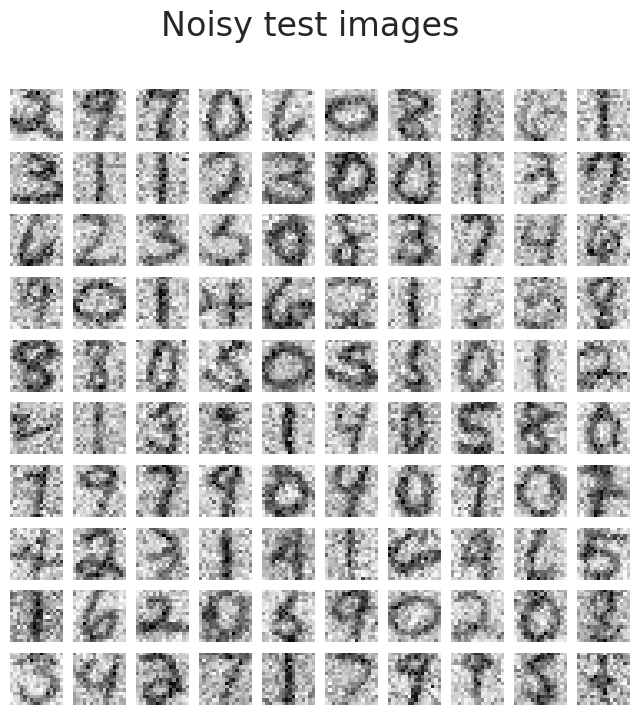

In [78]:
# Helper function for plotting the digit images
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(X_test_noisy, "Noisy test images")

Exercise 1 - Fitting PCA & Kernel PCA Objects
First, create a PCA object called pca and fit it to the noisy test set X_test_noisy. Do the same for KernelPCA object kernel_pca using a RBF kernel.

Be mindful that n_components has to be a number between 0 and min(n_samples, n_features) = 216 for PCA.

In [79]:
pca = PCA(n_components=35)
pca.fit(X_train_noisy)

kernel_pca = KernelPCA(n_components=400, kernel="rbf", gamma=0.01, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(X_train_noisy)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=0.01, kernel='rbf',
          n_components=400)

Exercise 2 - Reconstruct the Digits


Next, we want to see if PCA or kernel PCA is better at removing noise in the original images. To do so, recall how we reconstructed the make_circles toy dataset earlier in this lab. (Hint: apply inverse transformation to the transformed data on a lower dimension.)

In [80]:
X_hat_pca = pca.inverse_transform(pca.transform(X_test_noisy))

X_hat_kpca = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))

Exercise 3 - Visualize Denoised Digit Images
Now, let's visualize the images reconstructed from PCA and kernel PCA! You may find the helper function plot_digits helpful. Which one reveals digit images with less noise?

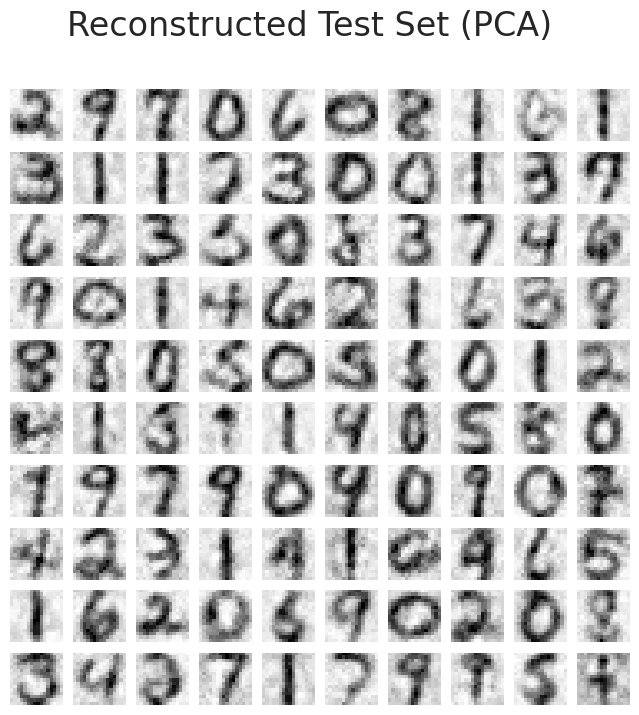

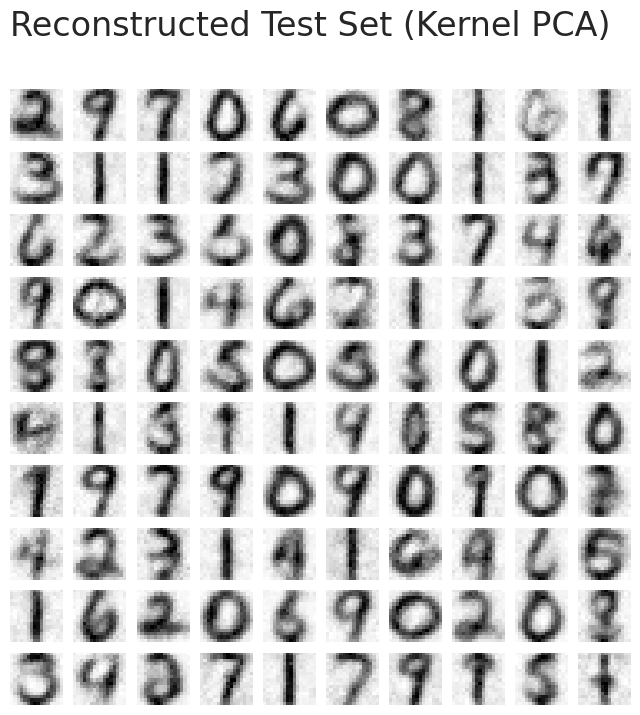

In [81]:
plot_digits(X_hat_pca, "Reconstructed Test Set (PCA)")

plot_digits(X_hat_kpca, "Reconstructed Test Set (Kernel PCA)")

lab  3

Multi-Dimensional Scaling
Estimated time needed: 45 minutes

Use cases of Multi-Dimensional Scaling
Recognizing families of parts in order to design cellular manufacturing systems.
Creating groups of products when designing assembly areas.
Market research, multi-dimensional scaling is often used to plot data such as the perception of products in an easy to interpret, visual way.
For instance, suppose a realtor has many listings to sell. Each listing has several attributes such as number of bedrooms, number of bathrooms, square feet, etc. You as a Data Scientist, are hired by the realtor to find out the similarities and dissimilarities of the listings, so that the brokers can use this information when providing recommendations for the buyers.

However, since the number of attributes each listing has is bigger than what could be visualized, to have a clearer sense of how different each listing is you would need to reproduce the listing data on a lower dimension.


Multi-Dimensional Scaling (MDS) is a family of algorithms, one version of which is Principal Component Analysis (PCA). Like PCA, MDS can be used for dimensionality reduction; MDS can also be used to map complex differences into visual space. Additional articles on MDS: [1], [2]

There are several different categories of Multidimensional scaling (MDS). In this lab, we will review Metric MDS as well as Non-Metric MDS scaling using scikit-learn library. For more information on MDS, please see [3].

Steps in MDS analysis:

Pre-process and generate training and testing datasets
Train and fine-tune logistic regression models
Interpret trained logistic regression models
Evaluate trained logistic regression models
Table of Contents
Objectives
Datasets
Setup
Installing Required Libraries
Importing Required Libraries
Defining-Helper-Functions
Metric MDS
From Relative Location to Absolute Location
Example 1
Non-Metric MDS
Dimensionality reduction with MDS
Exercise 1
T-Distributed Stochastic Neighbor Embedding (optional)
Objectives
After completing this lab you will be able to:

Understand different types of Multi-Dimensional Scaling
Understand concepts of Metric MDS and Non-Metric MDS, including: embedding space, minimization and Stress
Apply Metric-MDS and Non-Metric MDS
Apply different distance metrics to Metric MDS and Non-Metric MDS
Apply MDS to dimensionality reduction
Datasets
Datasets for this lab are gathered from the UCI Machine Learning Repository under the MIT License.

Setup
For this lab, we will be using the following libraries:

pandas for managing the data.
numpy for mathematical operations.
matplotlib for visualizing the data.
scipy for complex numerical operations.
sklearn for machine learning and machine-learning-pipeline related functions.







Installing Required Libraries
The following required modules are pre-installed in the Skills Network Labs environment. However if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda) you will need to install these libraries by removing the # sign before !mamba in the code cell below.

In [82]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba install -qy pandas==1.3.4 numpy==1.21.4 matplotlib==3.5.0 scikit-learn==0.20.1 scipy==1.7.3
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [83]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, cosine
import sklearn.metrics.pairwise
import seaborn as sns
import folium
# Import matplotlib for 3d plotting:
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
from matplotlib import offsetbox
# Make matplotlib work in jupyter notebook
%matplotlib inline

In [84]:
def plot_points(df,color="red",title=""):

    X=df['lon']
    Y=df['lat']

    annotations=df.index

    plt.figure(figsize=(8,6))
    plt.scatter(X,Y,s=100,color=color)
    plt.title(title)
    plt.xlabel("lat")
    plt.ylabel("log")
    for i, label in enumerate(annotations):
        plt.annotate(label, (X[i], Y[i]))
    plt.axis('equal')
    plt.show()

This function plots out labelled scatter plots of digits dataset in two dimensions after a Dimensionality reduction:

In [85]:
def plot_embedding(X, title, ax):
    X = MinMaxScaler().fit_transform(X)
    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

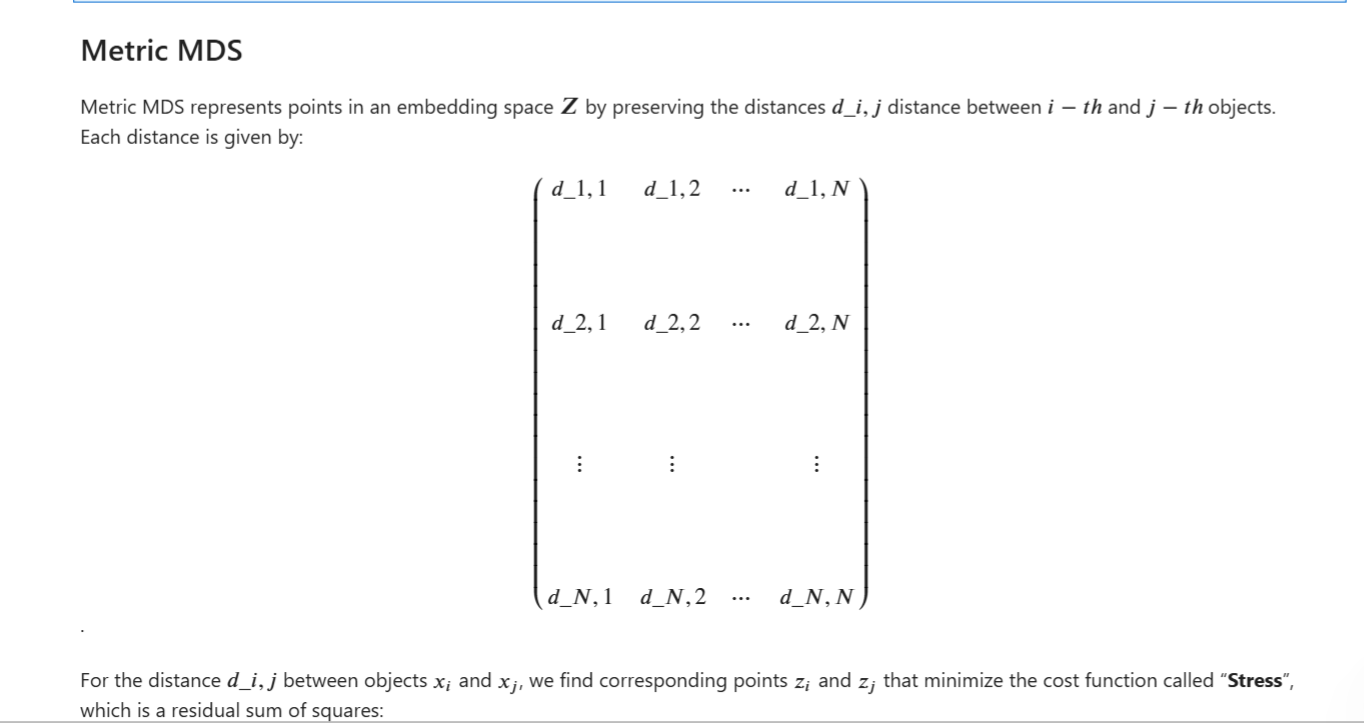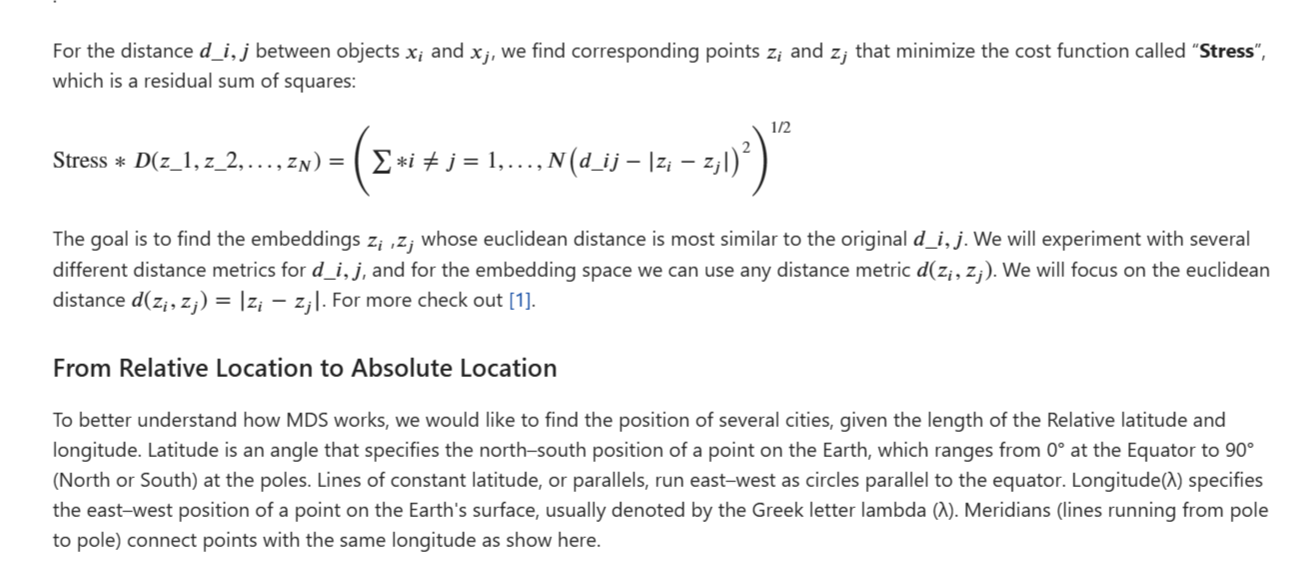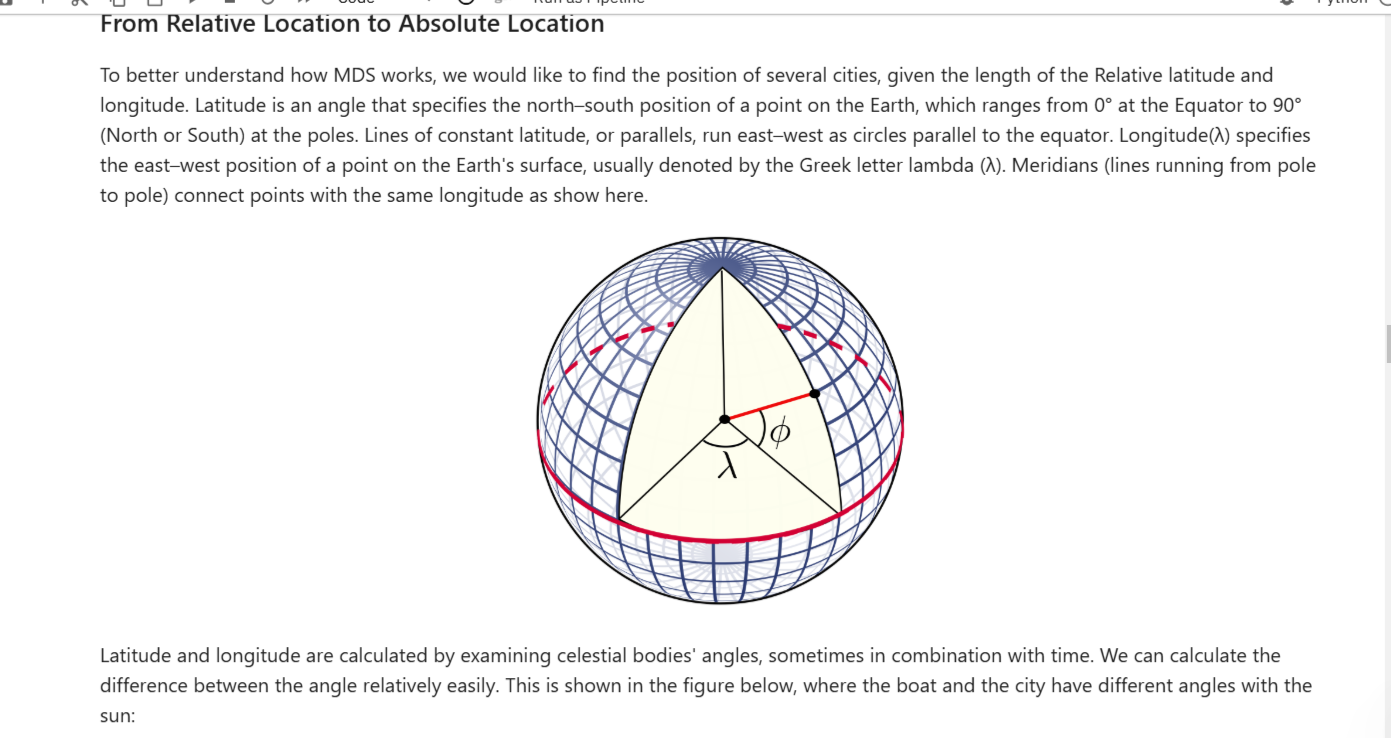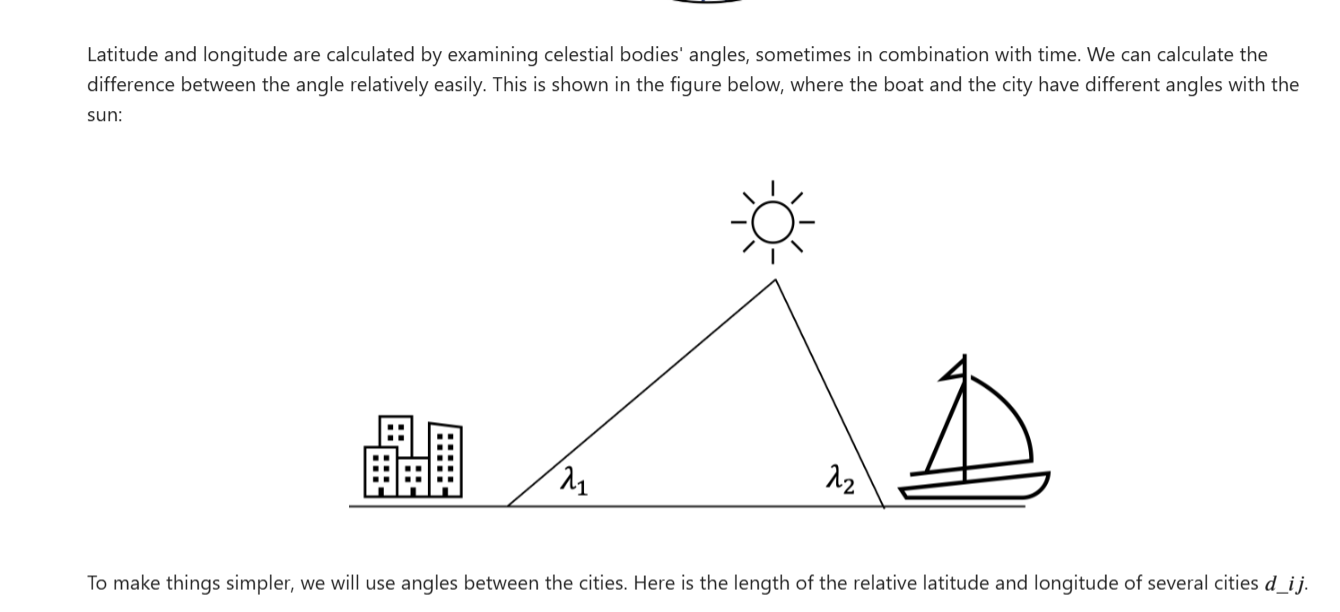

In [86]:
distance=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/distance.csv').set_index('name')
distance.head(8)

Buenos Aires  Paris  Melbourne  St Petersbourg  Abidjan  \
name                                                                      
Buenos Aires            0.00  83.00       4.00           93.93    39.33   
Paris                  83.00   0.00      87.00           10.93    43.67   
Melbourne               4.00  87.00       0.00           97.93    43.33   
St Petersbourg         93.93  10.93      97.93            0.00    54.60   
Abidjan                39.33  43.67      43.33           54.60     0.00   
Montreal               79.52   3.48      83.52           14.41    40.19   
Nairobi                32.71  50.29      36.71           61.22     6.62   
Salvador               21.03  61.97      25.03           72.90    18.30   

                Montreal  Nairobi  Salvador  
name                                         
Buenos Aires       79.52    32.71     21.03  
Paris               3.48    50.29     61.97  
Melbourne          83.52    36.71     25.03  
St Petersbourg     14.41    61.22     72.90  
Abidjan            40.19     6.62     18.30  
Montreal            0.00    46.81     58.49  
Nairobi            46.81     0.00     11.68  
Salvador           58.49    11.68      0.00

For Multidimensional Scaling in sklearn, we import the MDS constructor from the manifold module:

In [87]:
from sklearn.manifold import MDS

We create an MDS object embedding with the following parameters:







n_components: Number of dimensions in which to immerse the dissimilarities, default=2

precomputed: Pre-computed dissimilarities are passed directly to fit and fit_transform

max_iter : Maximum number of iterations of the SMACOF algorithm for a single run, default = 300

eps: Relative tolerance with respect to stress at which to declare convergence, default=1e-3

In [88]:
embedding =  MDS(dissimilarity='precomputed',n_components=2,random_state=0,max_iter=300,eps=1e-3)

We apply fit_transform to the data from distance array that fits the model and returns the embedded coordinates. The stress is minimized via SMACOF.

In [89]:
X_transformed = embedding.fit_transform(distance)

We then plot the coordinates as an 'X_transformed' approximation of the longitude and latitude.

In [90]:
df_t=pd.DataFrame(X_transformed , columns=["lon","lat"], index=distance.columns)
df_t.head(8)

lon        lat
Buenos Aires   -11.186300 -41.802565
Paris            9.513638  38.732017
Melbourne       -9.292359 -46.088042
St Petersbourg  16.549167  47.746633
Abidjan         -1.608445  -3.575219
Montreal         7.328738  35.794751
Nairobi         -3.001616 -10.072240
Salvador        -8.302824 -20.735334

We can also obtain the embeddings using the attribute embedding_.

In [91]:
embedding.embedding_

array([[-11.18630004, -41.80256455],
       [  9.5136384 ,  38.73201664],
       [ -9.2923592 , -46.08804169],
       [ 16.54916736,  47.74663293],
       [ -1.60844493,  -3.57521947],
       [  7.3287376 ,  35.79475057],
       [ -3.00161566, -10.07223994],
       [ -8.30282353, -20.7353345 ]])

We can obtain the stress (sum of squared distance of the disparities and the distances for all constrained points).

In [92]:
embedding.stress_

2.417240800968404

Finally, we will use the pairwise dissimilarity_matrix_ function.

In [93]:
embedding.dissimilarity_matrix_

array([[ 0.  , 83.  ,  4.  , 93.93, 39.33, 79.52, 32.71, 21.03],
       [83.  ,  0.  , 87.  , 10.93, 43.67,  3.48, 50.29, 61.97],
       [ 4.  , 87.  ,  0.  , 97.93, 43.33, 83.52, 36.71, 25.03],
       [93.93, 10.93, 97.93,  0.  , 54.6 , 14.41, 61.22, 72.9 ],
       [39.33, 43.67, 43.33, 54.6 ,  0.  , 40.19,  6.62, 18.3 ],
       [79.52,  3.48, 83.52, 14.41, 40.19,  0.  , 46.81, 58.49],
       [32.71, 50.29, 36.71, 61.22,  6.62, 46.81,  0.  , 11.68],
       [21.03, 61.97, 25.03, 72.9 , 18.3 , 58.49, 11.68,  0.  ]])

Let’s compare the embeddings to the longitude and latitude of each city.

In [94]:
# Make a data frame with dots to show on the map
df = pd.DataFrame({
   'lon':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
   'lat':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
   'name':['Buenos Aires', 'Paris', 'Melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador']})
df=df.set_index('name')
df.head(10)

lon    lat
name                         
Buenos Aires    -58.00 -34.00
Paris             2.00  49.00
Melbourne       145.00 -38.00
St Petersbourg   30.32  59.93
Abidjan          -4.03   5.33
Montreal        -73.57  45.52
Nairobi          36.82  -1.29
Salvador        -38.50 -12.97

We can compare the embeddings to the original data:

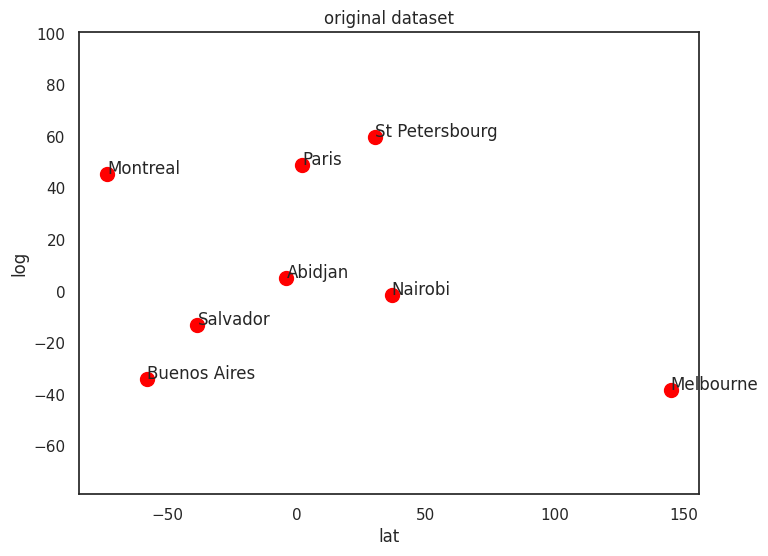

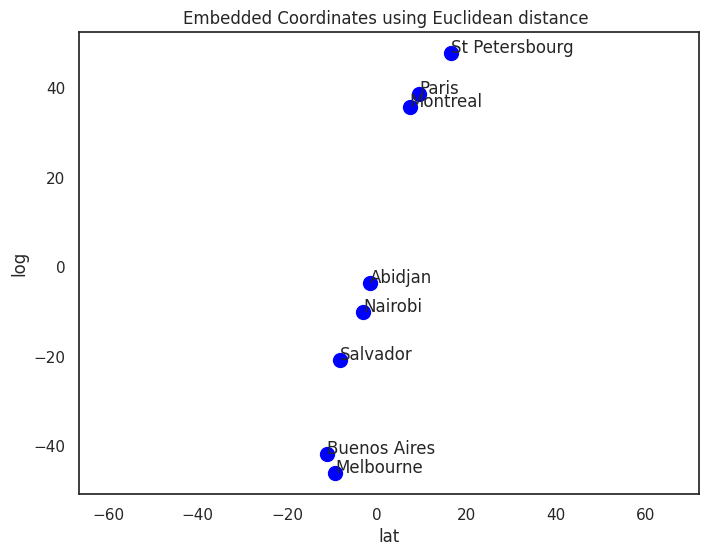

In [95]:
plot_points(df,title='original dataset')

plot_points(df_t,color='blue',title='Embedded Coordinates using Euclidean distance ')

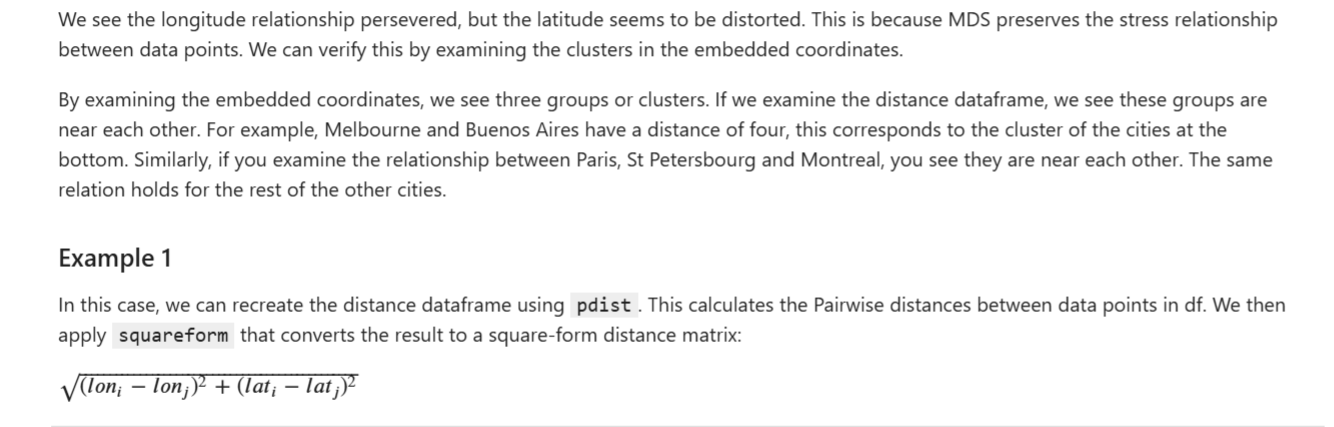

In [96]:
from scipy.spatial.distance import squareform, pdist

distance=pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df.index, index=df.index)

We see MDS clusters on the distance matrix; unlike the principal component analysis, we can apply different distances. In the following lines of code, we use other distance metrics on the longitude and latitude of different cities, then apply MDS. We plot out the results and see each distance has its own unique property.

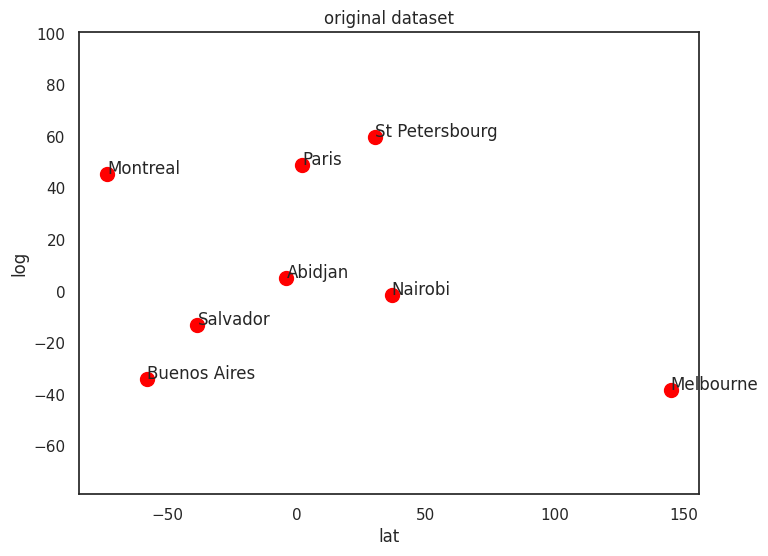

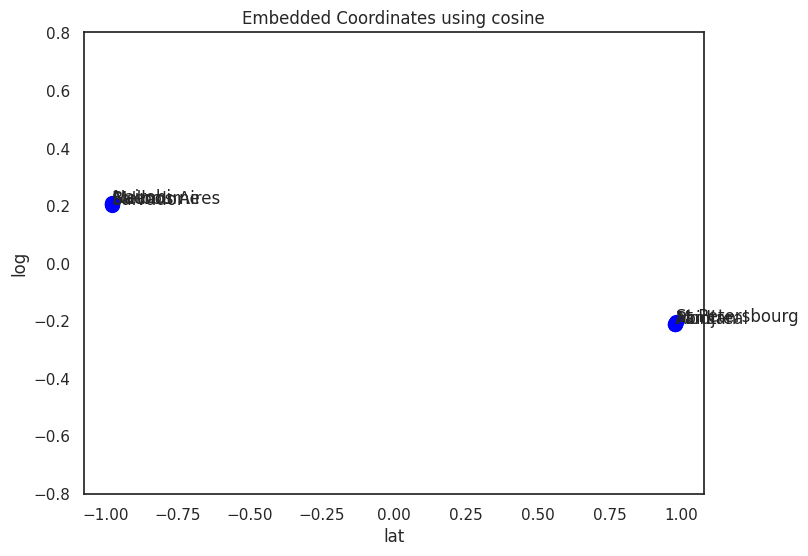

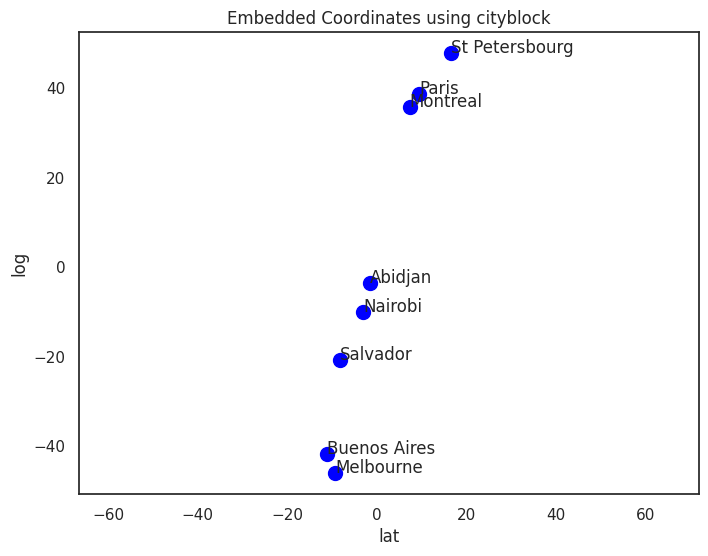

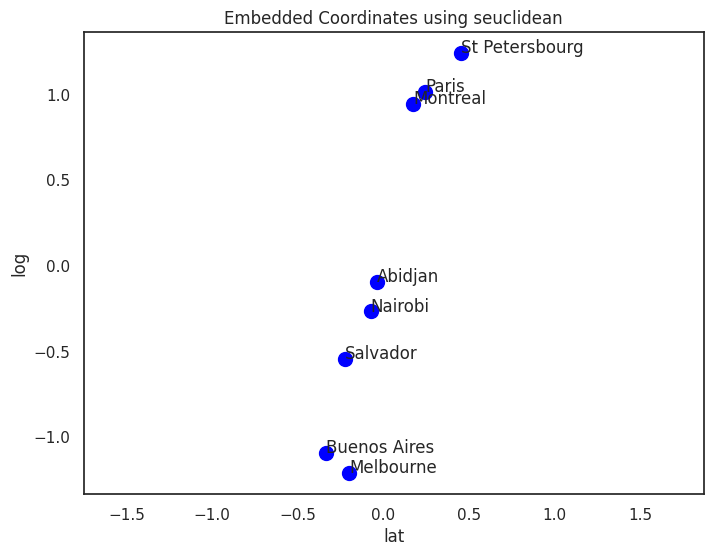

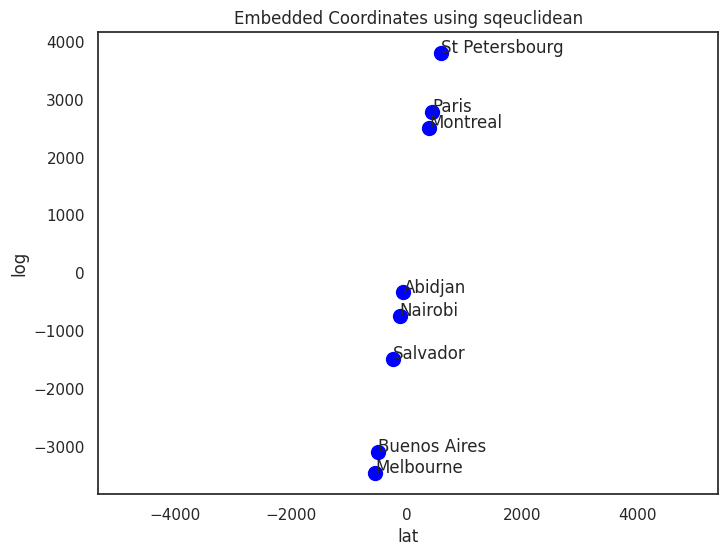

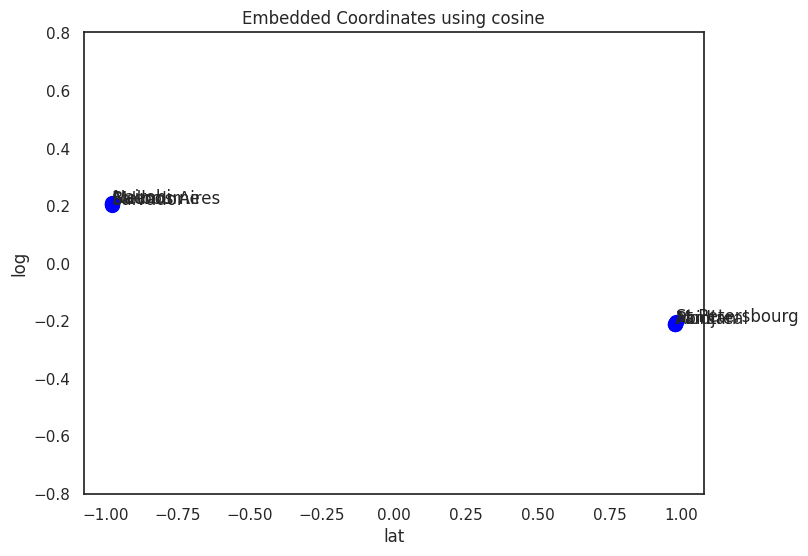

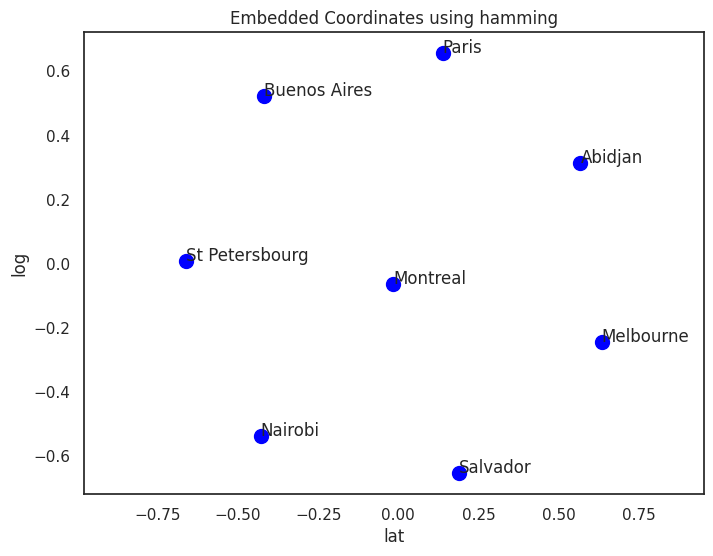

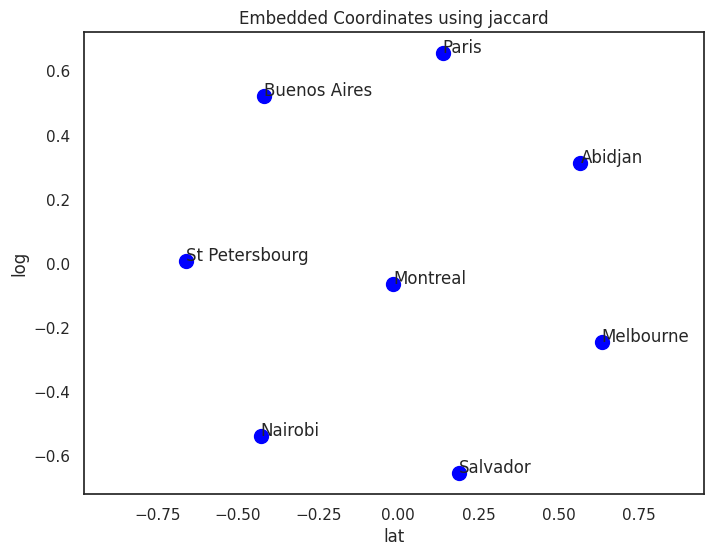

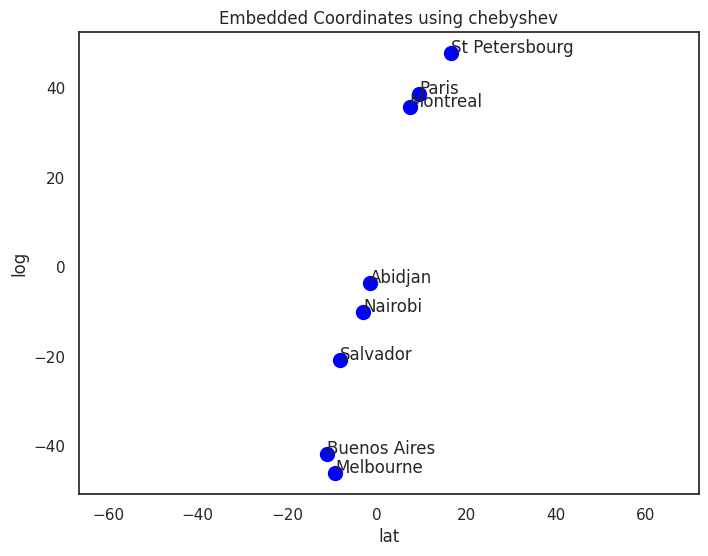

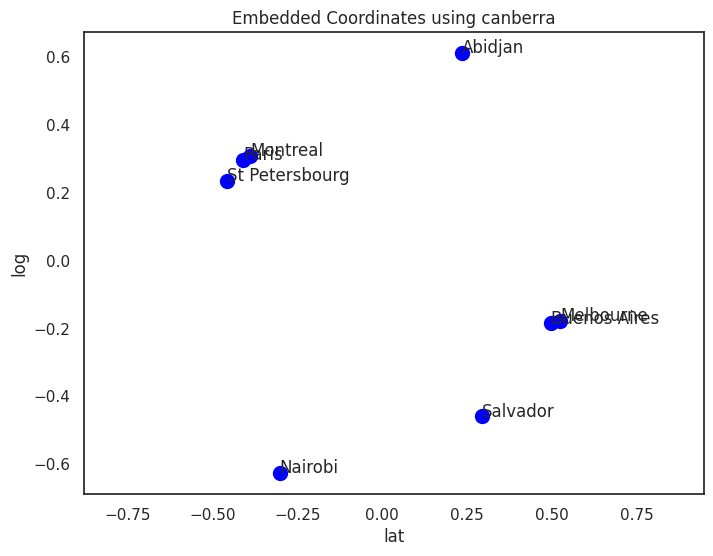

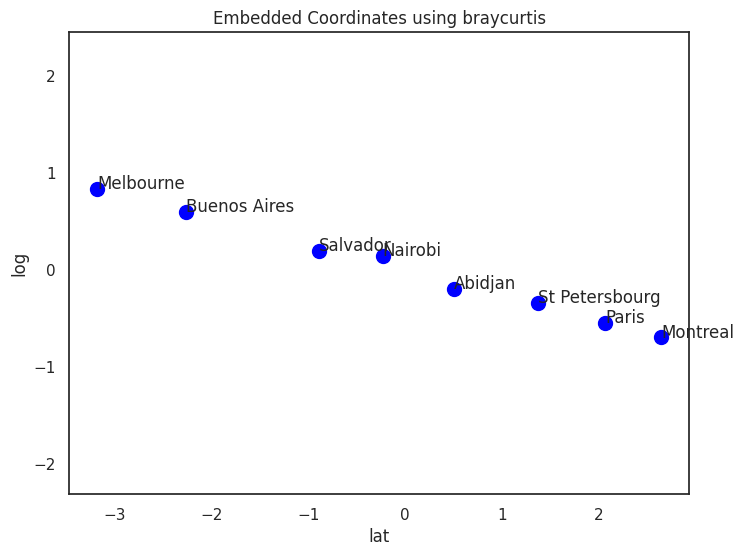

In [97]:
dist=['cosine','cityblock','seuclidean','sqeuclidean','cosine','hamming','jaccard','chebyshev','canberra','braycurtis']
plot_points(df,title='original dataset')
for d in dist:

    distance=pd.DataFrame(squareform(pdist(df.iloc[:, 1:],metric=d)), columns=df.index, index=df.index)

    embedding =  MDS(dissimilarity='precomputed', random_state=0,n_components=2)
    X_transformed = embedding.fit_transform(distance)
    df_t=pd.DataFrame(X_transformed , columns=df.columns, index=df.index)

    plot_points(df_t,title='Embedded Coordinates using '+d ,color='blue')

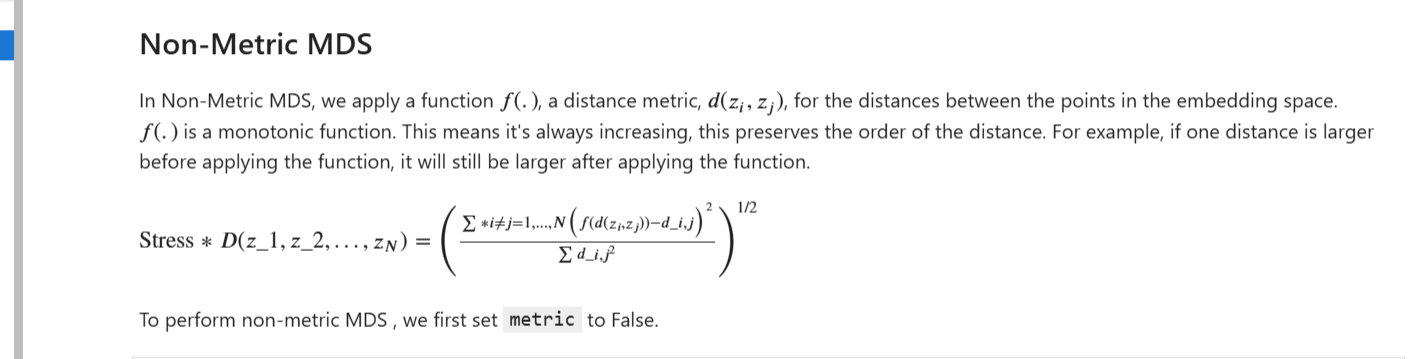

In [99]:
metric=False
embedding =  MDS(dissimilarity='precomputed',n_components=2,metric=metric,random_state=0)

We then apply fit_transform() to the data from array distance that fits the model and returns the embedded coordinates, and convert it to a dataframe:

In [100]:
X_transformed = embedding.fit_transform(distance)
df_t=pd.DataFrame(X_transformed , columns=df.columns, index=df.index)
df_t.head(8)

lon       lat
name                              
Buenos Aires   -0.482760 -0.171638
Paris           0.378508  0.179576
Melbourne      -0.442890 -0.223888
St Petersbourg  0.305767  0.254633
Abidjan         0.533921 -0.171974
Montreal        0.376625  0.129922
Nairobi        -0.184670  0.258346
Salvador       -0.507163 -0.285708

Non-metric MDS does better at preserving the horizontal scale, but the cities are negatively scaled in the longitudinal direction. At the same time, some cities like Paris and Montreal seem to have a different relationship in the latitudinal direction.

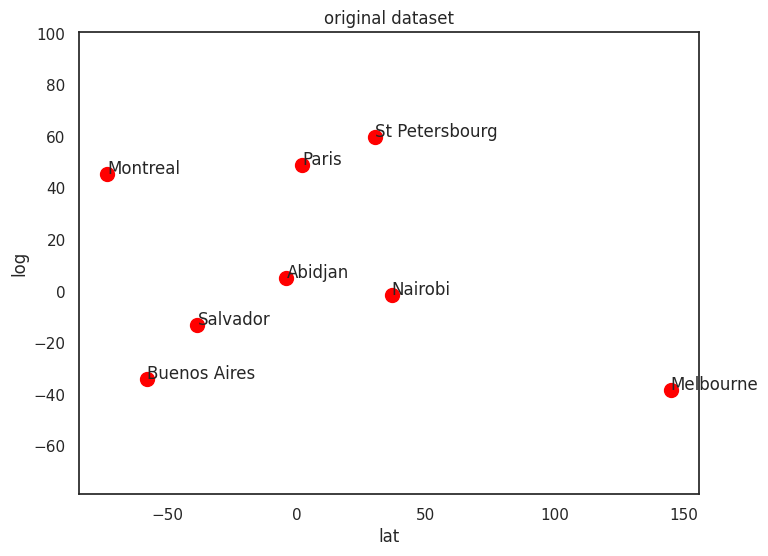

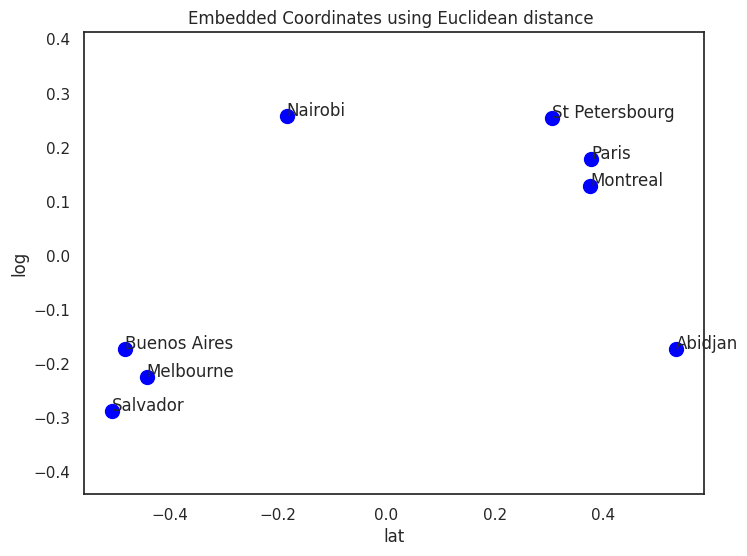

In [101]:
plot_points(df,title='original dataset')

plot_points(df_t,color='blue',title='Embedded Coordinates using Euclidean distance ')

We can also apply different distances to Non-Metric MDS.

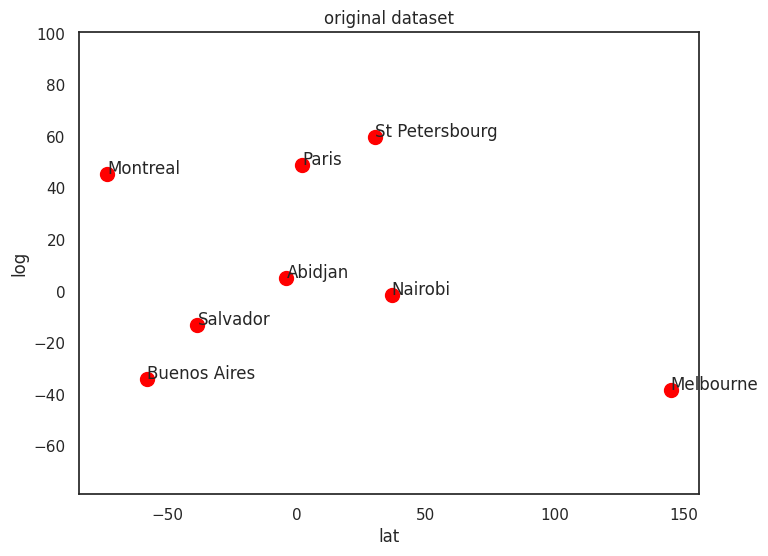

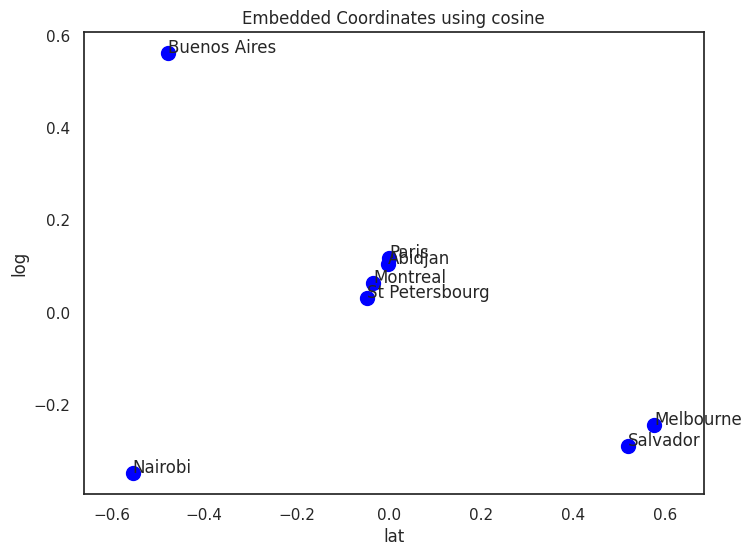

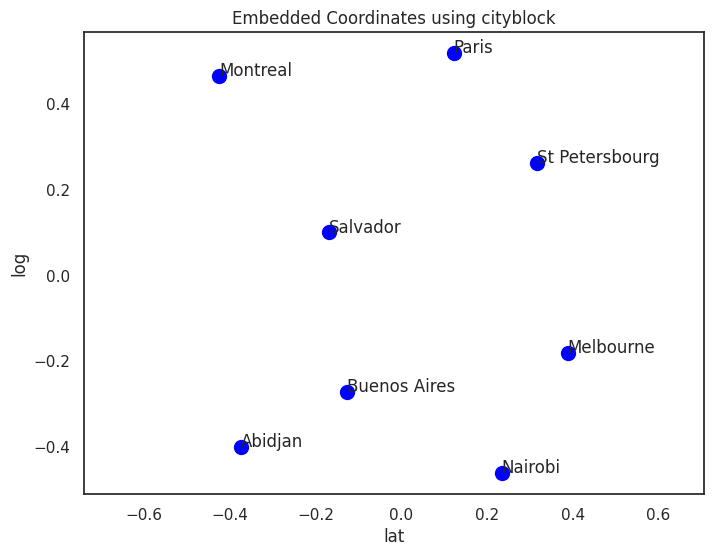

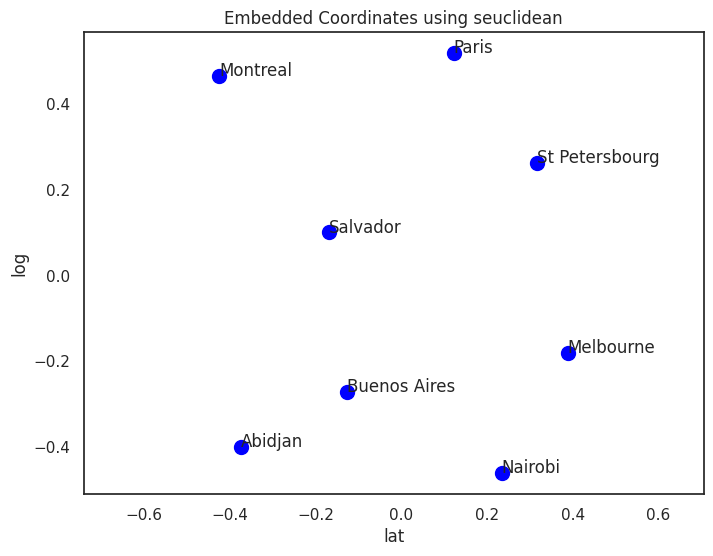

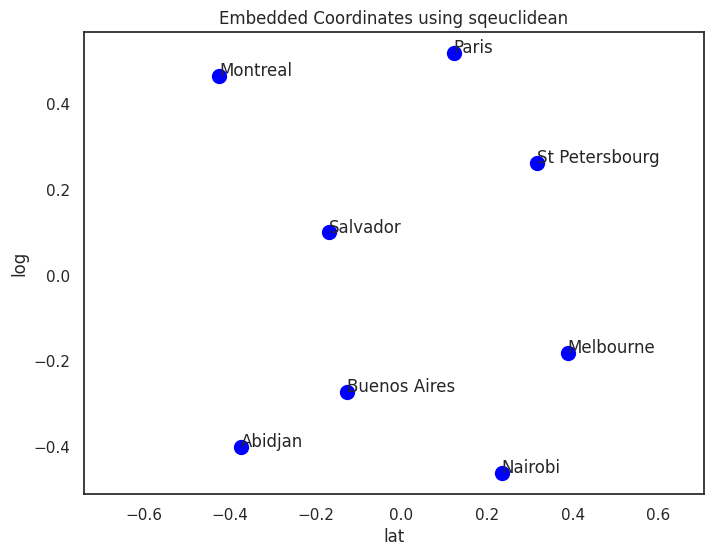

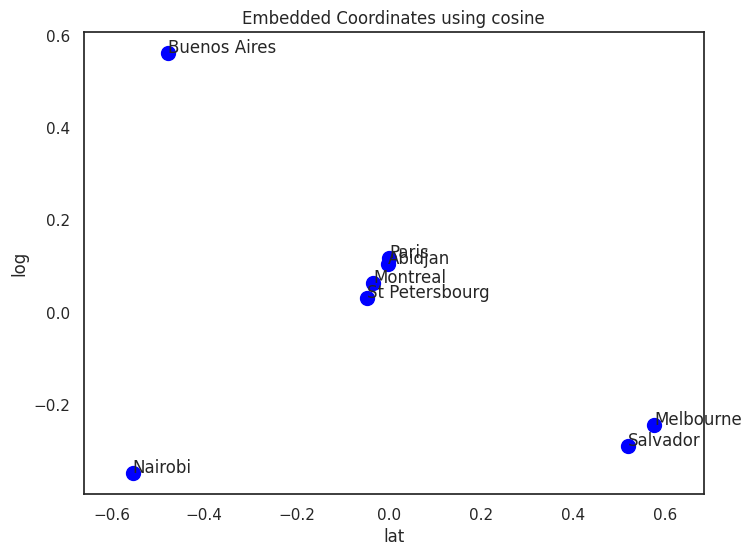

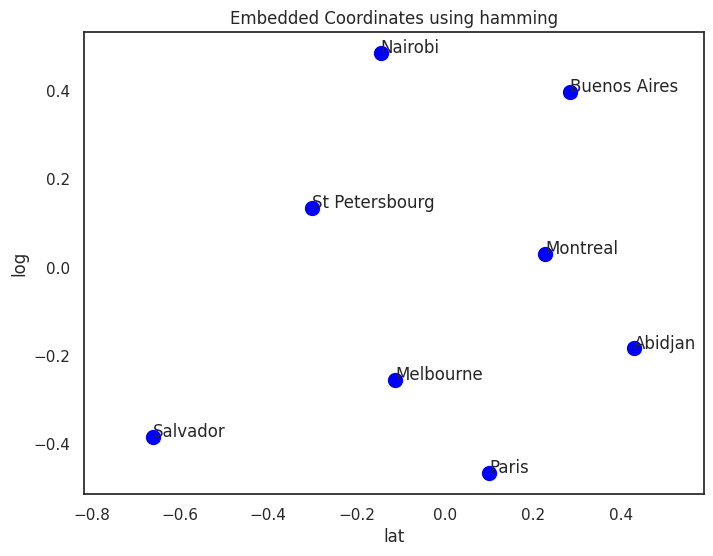

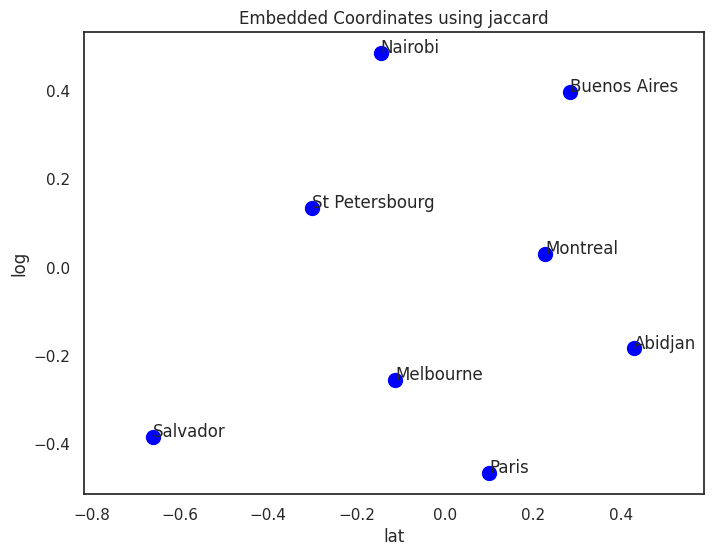

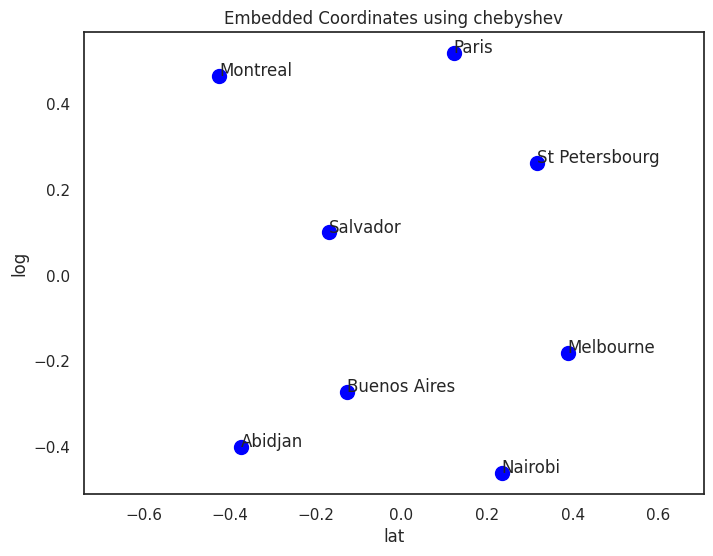

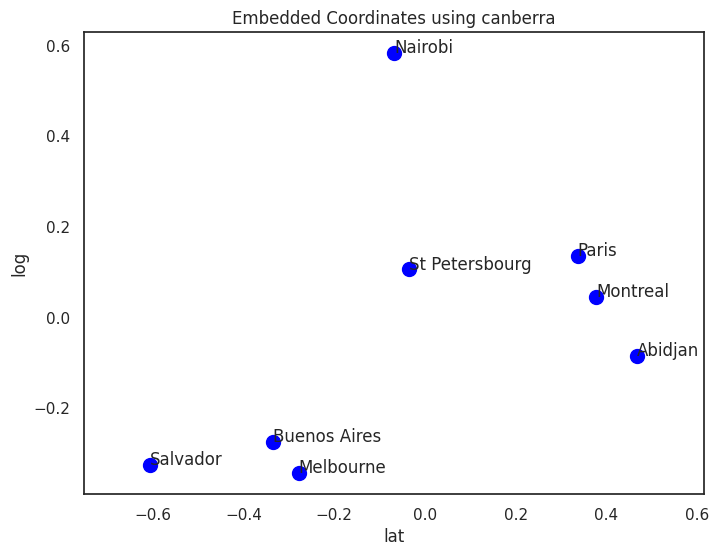

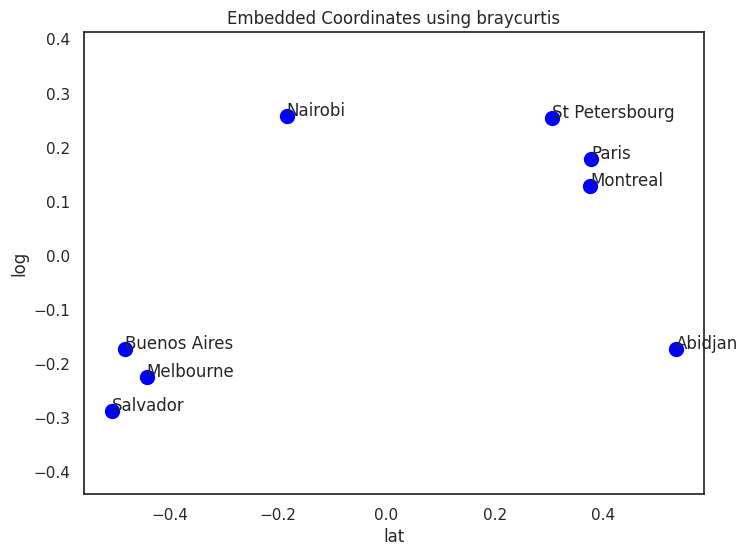

In [102]:
dist=['cosine','cityblock','seuclidean','sqeuclidean','cosine','hamming','jaccard','chebyshev','canberra','braycurtis']
plot_points(df,title='original dataset')
metric=False
for d in dist:

    distance=pd.DataFrame(squareform(pdist(df.iloc[:, 1:],metric=d)), columns=df.index, index=df.index)

    embedding =  MDS(dissimilarity='precomputed', random_state=0,n_components=2,metric=False)
    X_transformed = embedding.fit_transform(distance)
    df_t=pd.DataFrame(X_transformed , columns=df.columns, index=df.index)

    plot_points(df_t,title='Embedded Coordinates using '+d ,color='blue')

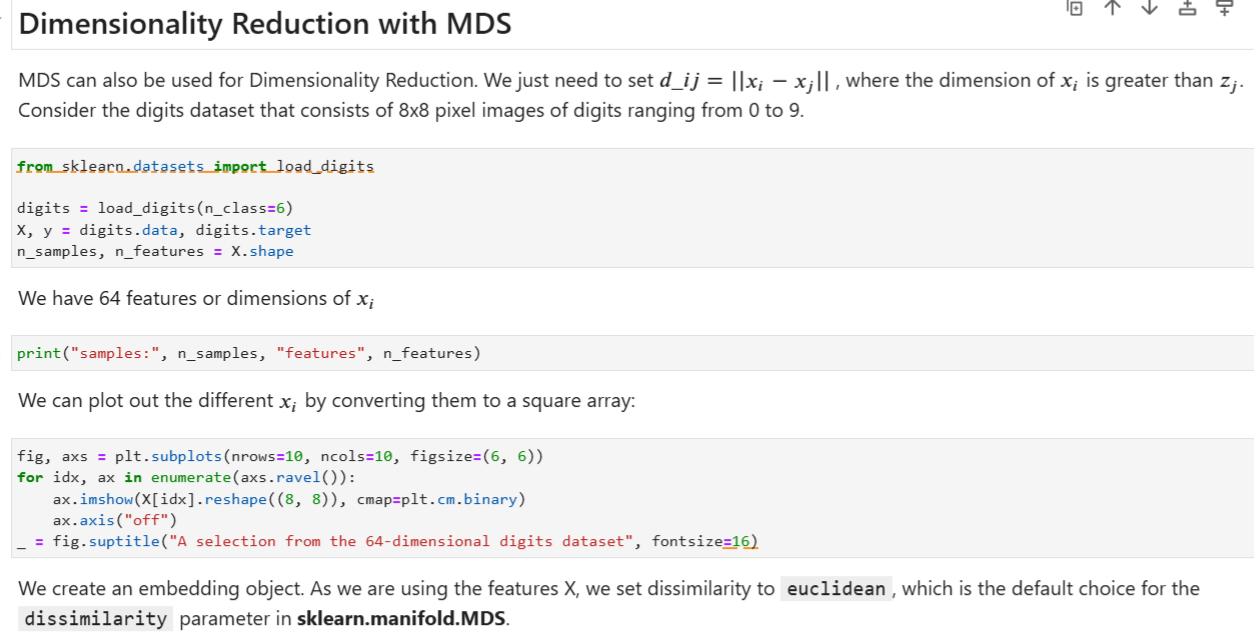

In [103]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape

In [104]:
print("samples:", n_samples, "features", n_features)

samples: 1083 features 64


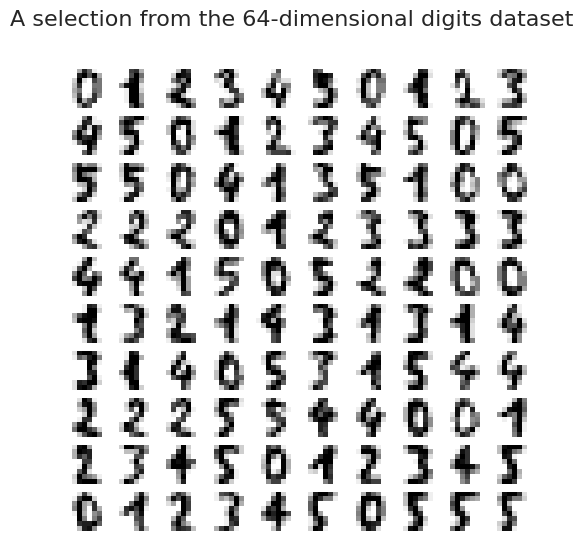

In [105]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [106]:
embedding=MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2)

We can apply MDS to the data X, we will fit the model and make a prediction simultaneously using the fit_transform method

In [107]:
X_transformed=embedding.fit_transform(X)

We plot the samples in the embedding space and overlay images of the digit and the colour representing the digit. We see that although there is some overlap, each cluster corresponds to a different digit, this is despite the fact that the method is unsupervised.

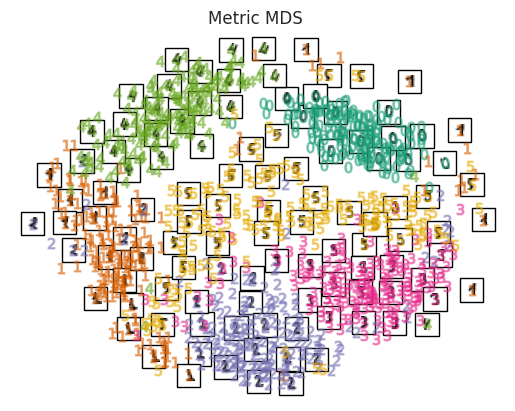

In [108]:
fig, ax = plt.subplots()
plot_embedding(X_transformed, "Metric MDS ", ax)
plt.show()

Exercise 1¶
In this exercise, you will apply metric MDS using different distance metrics in the list dist to the digit dataset X_norm that has been normalized.

cosine


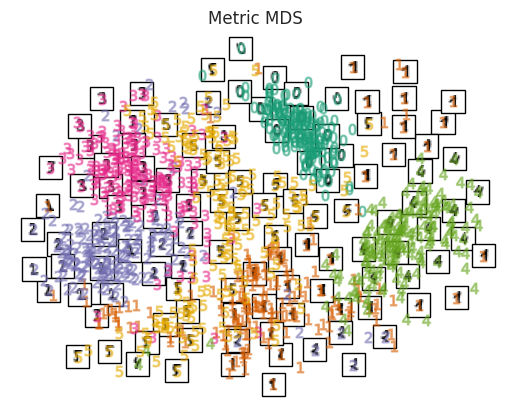

cityblock


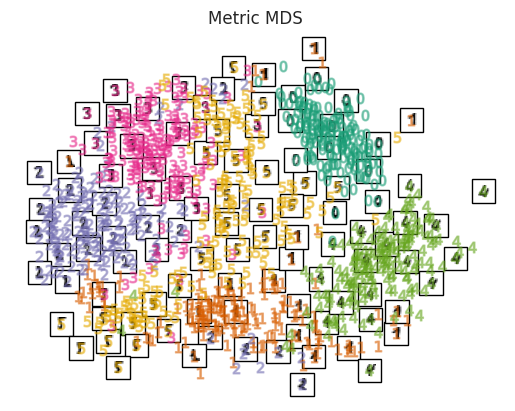

hamming


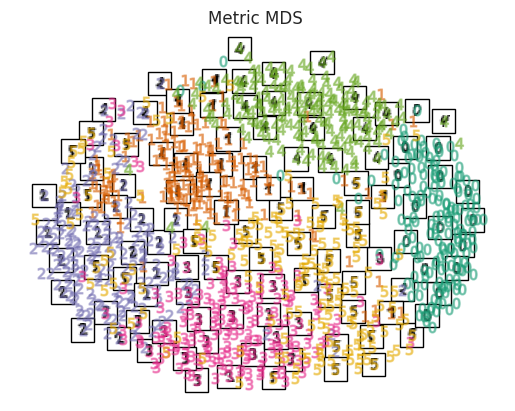

jaccard


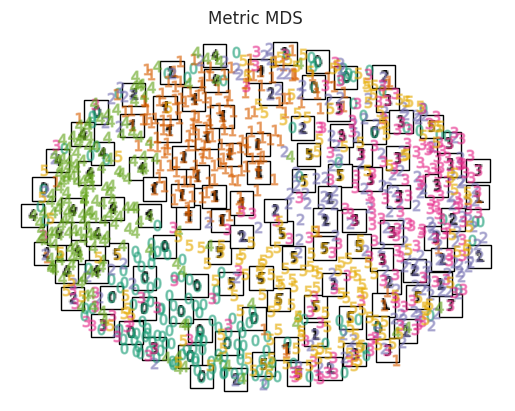

chebyshev


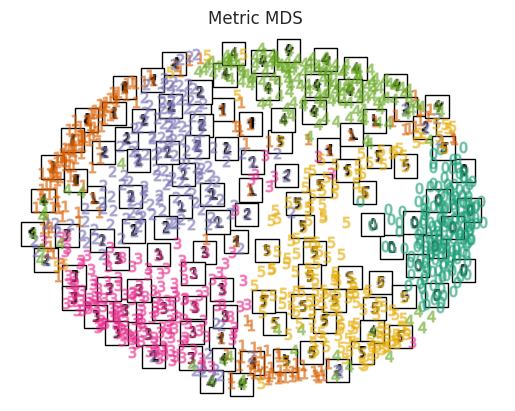

canberra


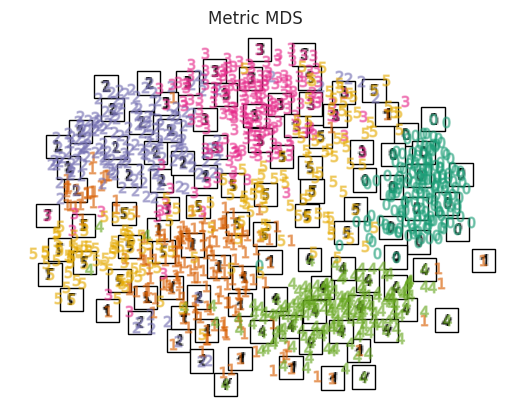

braycurtis


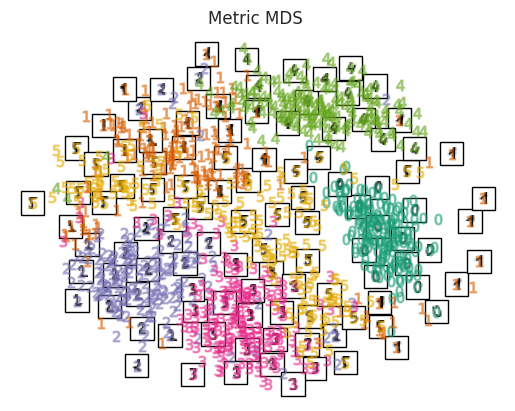

In [109]:
dist=['cosine','cityblock','hamming','jaccard','chebyshev','canberra','braycurtis']
scaler = MinMaxScaler()
X_norm=scaler.fit_transform(X)
for d in dist:

    distance=squareform(pdist(X_norm,metric=d))
    print( d)

    embedding =  MDS(dissimilarity='precomputed', random_state=0,n_components=2)
    X_transformed = embedding.fit_transform(distance)
    fig, ax = plt.subplots()
    plot_embedding(X_transformed, "Metric MDS ", ax)
    plt.show()

T-Distributed Stochastic Neighbor Embedding (optional)
T-Distributed Stochastic Neighbor Embedding (TSNE) is a method for visualizing high-dimensional data. It usually works better than MDS for visualizing data. The method is based on probabilities, unlike MDS, you can't use the distances.







We apply the algorithm to the same dataset. As we see the setup is very similar.

In [111]:
from sklearn.manifold import TSNE

In [112]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

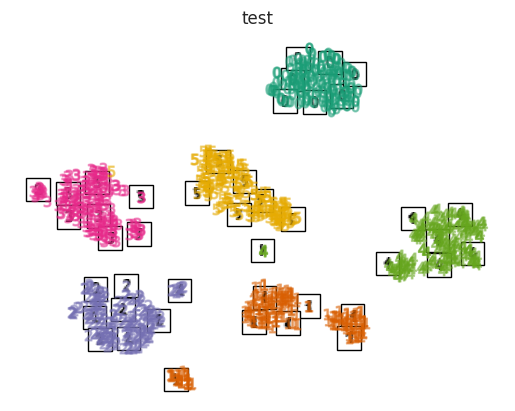

In [113]:
fig, ax = plt.subplots()
plot_embedding(X_embedded , "test", ax)
plt.show()